In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import Dataset, DataLoader
import json
from pathlib import Path
from transformer_lens.hook_points import HookPoint
from transformers import AutoTokenizer, AutoModelForCausalLM, PaliGemmaForConditionalGeneration
from sklearn.model_selection import train_test_split
import pandas as pd
import gc
import os
import matplotlib.pyplot as plt
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

# from random import random
import random
def seed_everywhere(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)    
SEED = 42
MAX_SEQ_LEN = 64 # location to truncate our inputs
DEVICE_1 = 'cuda:1'
DEVICE_2 = 'cuda:2' # the second GPU
NUM_CLASSES = 0
seed_everywhere(SEED)


# exp

In [39]:
class ActivationDataset(Dataset):
    """Dataset for model activations with labels"""
    def __init__(self, activations, labels):
        self.activations = torch.tensor(activations, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.activations)
    
    def __getitem__(self, idx):
        return self.activations[idx], self.labels[idx]

class LinearProbe(nn.Module):
    """Simple linear probe for classification"""
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        return self.linear(x)

class LinearProbingExperiment:
    def __init__(self, model_name="gemma", concept="animals"):
        self.model_name = model_name
        self.concept = concept
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
#     def load_activations(self, file_path):
#         """Load activations from file (assuming numpy format)"""
#         data = np.load(file_path, allow_pickle=True)
#         return data['activations'], data['labels']
    
    def train_sklearn_probe(self,
                             X_train: np.ndarray,
                             y_train: np.ndarray,
                             X_test: np.ndarray,
                             y_test: np.ndarray,
                             texts_test: list = None) -> tuple:
        """
        Train a sklearn logistic regression probe on flattened activations,
        and return the trained probe and a results dict including misclassified samples:
        - train_acc, test_acc, classification_report
        - y_test, y_pred
        - misclassified: list of dicts with index, text, true_label, pred_label
        """
        # Set random state for reproducibility
        probe = LogisticRegression(max_iter=1000, random_state=SEED)

        # Flatten sequence and hidden dimensions
        n_train_samples = X_train.shape[0]
        n_test_samples = X_test.shape[0]
        X_train_flat = X_train.reshape(n_train_samples, -1)
        X_test_flat = X_test.reshape(n_test_samples, -1)
        print(f"X_train_flat shape: {X_train_flat.shape}")
        print(f"y_train shape: {len(y_train)}")
        print(f"X_test_flat shape: {X_test_flat.shape}")
        print(f"y_test shape: {len(y_test)}")

        # Fit probe
        probe.fit(X_train_flat, y_train)

        # Predict
        train_pred = probe.predict(X_train_flat)
        test_pred = probe.predict(X_test_flat)

        # Compute metrics
        train_acc = accuracy_score(y_train, train_pred)
        test_acc = accuracy_score(y_test, test_pred)
        report = classification_report(y_test, test_pred)

        # Build results dict
        results = {
            'train_acc': train_acc,
            'test_acc': test_acc,
            'classification_report': report,
            'y_test': y_test.tolist() if hasattr(y_test, 'tolist') else list(y_test),
            'y_pred': test_pred.tolist(),
        }

        # Collect misclassified samples
        misclassified = []
        if texts_test is not None:
            for idx, (true_label, pred_label) in enumerate(zip(y_test, test_pred)):
                if true_label != pred_label:
                    misclassified.append({
                        'index': idx,
                        'text': texts_test[idx],
                        'true_label': int(true_label),
                        'pred_label': int(pred_label)
                    })
        results['misclassified'] = misclassified

        return probe, results
    
    def train_torch_probe(self, X_train, y_train, X_test, y_test, epochs=100):
        """Train PyTorch linear probe"""
        input_dim = X_train.shape[0] # is this "how many text snppets"?
#         num_classes = len(np.unique(y_train)) 
        num_classes = NUM_CLASSES # let's do binary classifier
    # TODO: let's imitate sigmoid
        train_dataset = ActivationDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        
        probe = LinearProbe(input_dim, num_classes).to(self.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(probe.parameters(), lr=0.001)
        
        # Training loop
        for epoch in range(epochs):
            probe.train()
            total_loss = 0
            for batch_x, batch_y in train_loader:
                batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)
                
                optimizer.zero_grad()
                outputs = probe(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
            
            if epoch % 20 == 0:
                print(f"Epoch {epoch}, Loss: {total_loss/len(train_loader):.4f}")
        
        # Evaluation
        probe.eval()
        with torch.no_grad():
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(self.device)
            test_outputs = probe(X_test_tensor)
            test_pred = torch.argmax(test_outputs, dim=1).cpu().numpy()
            
            X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(self.device)
            train_outputs = probe(X_train_tensor)
            train_pred = torch.argmax(train_outputs, dim=1).cpu().numpy()
        
        results = {
            'train_acc': accuracy_score(y_train, train_pred),
            'test_acc': accuracy_score(y_test, test_pred),
            'classification_report': classification_report(y_test, test_pred)
        }
        
        return probe, results
    
    def run_experiment(self, gemma_activations, gemma_labels, 
                      polygemma_activations, polygemma_labels):
        """Run complete probing experiment"""
        print(f"Running linear probing experiment: {self.concept}")
        print(f"Gemma training data: {gemma_activations.shape}")
        print(f"PolyGemma test data: {polygemma_activations.shape}")
        
        # Train on Gemma, test on PolyGemma
        results = {}
    
        
        # sklearn probe
        print("\n--- Training sklearn probe ---")
        # Do the split!
        gemma_activations_train, _, gemma_labels_train, _  = train_test_split(gemma_activations, gemma_labels, test_size=0.2, random_state=SEED)
        _, polygemma_activations_test, _, polygemma_labels_test = train_test_split(polygemma_activations, polygemma_labels, test_size=0.2, random_state=SEED)
        print(f"size of gemma_activations_train: {gemma_activations_train.shape}, size of gemma_labels_train: {len(gemma_labels_train)}")
        print(f"size of polygemma_activations_test: {polygemma_activations_test.shape}, size of polygemma_labels_test: {len(polygemma_labels_test)}")
        try:
            gemma_activations_train = gemma_activations_train.cpu()
            polygemma_activations_test = polygemma_activations_test.cpu()
        except:
            pass
        sklearn_probe, sklearn_results = self.train_sklearn_probe(
            gemma_activations_train, gemma_labels_train, # train
            polygemma_activations_test, polygemma_labels_test # test
        )
        results['sklearn'] = sklearn_results
        
#         # PyTorch probe
#         print("\n--- Training PyTorch probe ---")
#         torch_probe, torch_results = self.train_torch_probe(
#             gemma_activations, gemma_labels, # train
#             polygemma_activations, polygemma_labels # test
#         )
#         results['torch'] = torch_results
        
        return sklearn_probe, results
    
    def save_results(self, results, output_path):
        """Save experiment results"""
        output_path = Path(output_path)
        output_path.parent.mkdir(parents=True, exist_ok=True)
        
        # Convert numpy types to Python types for JSON serialization
        def convert_numpy(obj):
            if isinstance(obj, np.integer):
                return int(obj)
            elif isinstance(obj, np.floating):
                return float(obj)
            elif isinstance(obj, np.ndarray):
                return obj.tolist()
            return obj
        
        json_results = json.loads(json.dumps(results, default=convert_numpy))
        
        with open(output_path, 'w') as f:
            json.dump(json_results, f, indent=2)



# synth data

In [25]:
# # Synthetic text data for cat/dog classification
# text = [
#     # Cat examples (label 0)
#     "The fluffy cat purred softly on the windowsill, watching birds outside.",
#     "My kitten loves to chase the red laser pointer around the living room.",
#     "The orange tabby cat stretched lazily in the warm afternoon sunlight.",
#     "She adopted a rescue cat from the local animal shelter last week.",
#     "The cat's whiskers twitched as it stalked the toy mouse across the floor.",
#     "Fluffy meowed loudly when her food bowl was empty this morning.",
#     "The black cat gracefully jumped onto the kitchen counter with ease.",
#     "My feline friend enjoys napping in cardboard boxes all day long.",
#     "The cat's green eyes glowed mysteriously in the dim moonlight tonight.",
#     "Her pet cat brings dead mice to the doorstep every morning.",
#     "The Siamese cat has the most beautiful blue eyes I've ever seen.",
#     "Tom cat climbed up the tall oak tree to escape the neighborhood dogs.",
#     "The veterinarian said the kitten needs its vaccinations next month.",
#     "My cat purrs so loudly it sounds like a tiny motor running.",
#     "The calico cat had three adorable kittens in the barn yesterday.",
#     "She trained her cat to use the toilet instead of a litter box.",
#     "The Persian cat's long fur requires daily brushing to prevent matting.",
#     "My indoor cat watches wildlife documentaries on TV with great interest.",
#     "The stray cat finally trusted me enough to eat from my hand.",
#     "Her cat knocked over the expensive vase while chasing a butterfly.",
    
#     # Dog examples (label 1)
#     "The golden retriever barked excitedly when his owner came home today.",
#     "My dog loves to fetch tennis balls in the backyard every afternoon.",
#     "The small puppy wagged its tail when meeting new people yesterday.",
#     "She takes her German shepherd for long walks in the park.",
#     "The dog's tail wagged furiously when it saw the treat jar.",
#     "Max barked at the mailman who comes by every morning.",
#     "The border collie herded the sheep expertly across the green field.",
#     "My canine companion loves swimming in the lake during hot summers.",
#     "The dog trainer taught the puppy basic commands like sit and stay.",
#     "Her loyal dog waited patiently outside the grocery store for her.",
#     "The beagle's nose led it straight to the hidden treats upstairs.",
#     "My dog howls along with the sirens from passing fire trucks.",
#     "The veterinarian recommended a special diet for the overweight bulldog.",
#     "The rescue dog was nervous but gradually warmed up to us.",
#     "My puppy chewed up my favorite pair of running shoes yesterday.",
#     "The dog park was crowded with excited pups playing together today.",
#     "Her service dog helps her navigate safely through busy city streets.",
#     "The hunting dog pointed steadily at the birds hiding in bushes.",
#     "My dog greets every visitor with enthusiastic tail wagging and jumping.",
#     "The old dog slept peacefully by the fireplace on cold nights.",
    
#     # Neutral/other examples (label 2) - neither cats nor dogs
#     "The morning sun cast beautiful shadows across the empty parking lot.",
#     "She enjoyed reading mystery novels while drinking her evening tea.",
#     "The mathematics professor explained complex equations on the whiteboard clearly.",
#     "Fresh vegetables from the farmers market made an excellent dinner tonight.",
#     "The old library contained thousands of books on various subjects.",
#     "He repaired the broken bicycle tire using tools from the garage.",
#     "The weather forecast predicted rain for the entire weekend ahead.",
#     "Students gathered in the cafeteria to discuss their upcoming project.",
#     "The concert featured amazing performances by local musicians and bands.",
#     "She planted colorful flowers in her garden beds this spring.",
#     "The computer program crashed unexpectedly during the important presentation today.",
#     "Ocean waves crashed against the rocky cliffs during the storm.",
#     "The chef prepared an elaborate feast for the wedding celebration.",
#     "Mountains covered in snow looked majestic against the clear sky.",
#     "The museum displayed artifacts from ancient civilizations throughout history.",
#     "Traffic was heavy on the highway during rush hour yesterday.",
#     "The smartphone battery died right before the important phone call.",
#     "Autumn leaves fell gently from the trees in vibrant colors.",
#     "The construction workers finished building the new bridge ahead of schedule.",
#     "She studied diligently for her final exams in the quiet library."
# ]

# # Corresponding labels: 0=cat, 1=dog, 2=neutral
# labels = [
#     # Cat labels (0)
#     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#     # Dog labels (1) 
#     1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
#     # Neutral labels (2)
#     2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2
# ]

# # Verify data consistency
# print(f"Total texts: {len(text)}")
# print(f"Total labels: {len(labels)}")
# print(f"Cat examples: {labels.count(0)}")
# print(f"Dog examples: {labels.count(1)}")
# print(f"Neutral examples: {labels.count(2)}")

# COCO annotations & images

In [26]:
SAVE_DIR = '../data'

cat_df = pd.read_csv(f'{SAVE_DIR}/coco_val2017_cat_binary_with_captions_balanced.csv')
cat_df = cat_df.sample(n=min(len(cat_df), 1000), random_state=SEED)

dog_df = pd.read_csv(f'{SAVE_DIR}/coco_val2017_dog_binary_with_captions_balanced.csv')
dog_df = dog_df.sample(n=min(len(dog_df), 1000), random_state=SEED)

human_df = pd.read_csv(f'{SAVE_DIR}/coco_val2017_human_binary_with_captions_balanced.csv')
human_df = human_df.sample(n=min(len(human_df), 1000), random_state=SEED)

cat_df.captions = cat_df.captions.apply(lambda x:eval(x)[0])
dog_df.captions = dog_df.captions.apply(lambda x:eval(x)[0])
human_df.captions = human_df.captions.apply(lambda x:eval(x)[0])

In [27]:
cat_df, cat_df.label.value_counts()

(     image_id         file_name  \
 165     42888  000000042888.jpg   
 33     532493  000000532493.jpg   
 15     153299  000000153299.jpg   
 312    284623  000000284623.jpg   
 57     329319  000000329319.jpg   
 ..        ...               ...   
 71     492282  000000492282.jpg   
 106      2153  000000002153.jpg   
 270    364297  000000364297.jpg   
 348      6894  000000006894.jpg   
 102    455219  000000455219.jpg   
 
                                               captions  label  
 165  A corner street sign with a tow sign and a art...      0  
 33      A surfer on a white board riding a small wave.      0  
 15   two giraffes are standing together outside a barn      0  
 312               A black cat sits in a bathroom sink.      1  
 57   A black and white cat sitting on top of a wood...      1  
 ..                                                 ...    ...  
 71    A man who is riding a horse down a brick street.      0  
 106  Batter preparing to swing at pitch durin

In [ ]:
# import os, io, concurrent.futures
# import pandas as pd
# from PIL import Image
# import torch
# from transformers import AutoProcessor, PaliGemmaForConditionalGeneration


# def vision_feats_from_bytes(byte_list):
#     imgs = [Image.open(io.BytesIO(b)).convert("RGB") for b in byte_list]
#     batch = processor(images=imgs, return_tensors="pt")
#     batch = {k: v.to(model.device) for k, v in batch.items()}

#     with torch.no_grad():
#         vout = model.vision_tower(
#             pixel_values=batch["pixel_values"],
#             output_hidden_states=True, return_dict=True
#         )

#     # Choose a layer/aggregation for your probe:
#     # - CLS token if the encoder has one (often index 0)
#     # - Mean pool over patch tokens
#     # Many people use the penultimate layer for probes:
#     last_hidden = vout.hidden_states[-2]   # (B, N_tokens, D)
#     # If there is a CLS token: feats = last_hidden[:, 0]
#     feats = last_hidden.mean(dim=1)        # mean pool over tokens -> (B, D)
#     return feats  # detach if you like: feats.detach()

# def _read_bytes(path: str) -> bytes:
#     with open(path, "rb") as f:
#         return f.read()

# def preload_image_bytes(df: pd.DataFrame, root: str, max_workers: int = 8) -> dict:
#     paths = [os.path.join(root, fn) for fn in df["file_name"]]
#     with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as ex:
#         data = list(ex.map(_read_bytes, paths))
#     # map by file_name (or image_id if you prefer)
#     return dict(zip(df["file_name"], data))

# data_name = 'cat'
# ROOT = f"../data/coco_val2017_{data_name}_binary_with_captions_balanced_images"  # where 000000323303.jpg etc. live

# # ---- load to RAM (compressed) ----
# byte_cache = preload_image_bytes(cat_df, ROOT, max_workers=12)

# # ---- PaliGemma setup ----
# model_id = "google/paligemma2-3b-pt-224"
# dtype = torch.float32
# model = PaliGemmaForConditionalGeneration.from_pretrained(
#     model_id, torch_dtype=dtype, device_map="auto"
# )
# model.vision_tower.config.output_hidden_states = True
# processor = AutoProcessor.from_pretrained(model_id)

# # ---- build a batch from in-RAM bytes and run forward/generate ----
# def make_batch_from_bytes(filenames, prompts):
#     imgs = [Image.open(io.BytesIO(byte_cache[fn])).convert("RGB") for fn in filenames]
#     # Processor handles resizing/normalization
#     inputs = processor(images=imgs, text=prompts, return_tensors="pt", padding=True)
#     return {k: v.to(model.device) for k, v in inputs.items()}

# # Example: yes/no “cat” probe for a subset
# filenames = cat_df["file_name"].head(16).tolist()
# prompts = ["Is there a cat in this image? Answer yes or no."] * len(filenames)

# with torch.no_grad():
#     batch = make_batch_from_bytes(filenames, prompts)
#     out = model.generate(**batch, max_new_tokens=5)

# preds = processor.batch_decode(out, skip_special_tokens=True)
# print(preds)


In [ ]:
cat_df.captions.map(len)

In [29]:
texts_list, labels_list, filenames_list = [], [], [] # We don;t save imgs deitecely in RAM since that's not efficient

In [30]:
cat_texts, cat_labels, cat_filenames = cat_df.captions.tolist(), cat_df.label.tolist(), cat_df.file_name.tolist()
texts_list.append(cat_texts), labels_list.append(cat_labels), filenames_list.append(cat_filenames)
print(f"length of cat_texts: {len(cat_texts)}, length of cat_labels: {len(cat_labels)}")
dog_texts, dog_labels, dog_filenames = dog_df.captions.tolist(), dog_df.label.tolist(), dog_df.file_name.tolist()
texts_list.append(dog_texts), labels_list.append(dog_labels), filenames_list.append(dog_filenames)
print(f"length of cat_texts: {len(cat_texts)}, length of cat_labels: {len(cat_labels)}")
human_texts, human_labels, human_filenames = human_df.captions.tolist(), human_df.label.tolist(), human_df.file_name.tolist()
texts_list.append(human_texts), labels_list.append(human_labels), filenames_list.append(human_filenames)
print(f"length of human_texts: {len(human_texts)}, length of human_labels: {len(human_labels)}")

length of cat_texts: 368, length of cat_labels: 368
length of cat_texts: 368, length of cat_labels: 368
length of human_texts: 1000, length of human_labels: 1000


# load model & get act

In [38]:
def load_models_with_eval(model_name, device="cuda"):
    if "paligemma" in model_name.lower():
        from transformers import PaliGemmaForConditionalGeneration
        model = PaliGemmaForConditionalGeneration.from_pretrained(
            model_name, 
            trust_remote_code=True,
            torch_dtype=torch.float32,  # Use fp16 for memory efficiency
            device_map=None  # We'll handle device placement manually
        )
        model = model.to(device)
        language_model = model.language_model
    else:
        model = AutoModelForCausalLM.from_pretrained(
            model_name, 
            trust_remote_code=True,
            torch_dtype=torch.float32,
            device_map=None
        )
        model = model.to(device)
        language_model = model
            
    language_model.eval()
    return language_model

def get_inputs_from_text(model_name, text, device):
#     if "pali" not in model_name:
#         tokenizer = AutoTokenizer.from_pretrained("google/paligemma2-3b-pt-224", use_fast=True) # Let's use paligemma tokeniser to avoid BOS token (same as in SAEs)
#     else:
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # FIXED: More robust tokenization with proper padding token handling
    # Ensure we have a pad token

    # Tokenize with safer parameters
    inputs = tokenizer(
        text, 
        return_tensors="pt", 
        padding="max_length",
        truncation=True,
        max_length=MAX_SEQ_LEN,
        add_special_tokens=True  # Ensure special tokens are added properly
    )
    if tokenizer.bos_token_id is not None:
        inputs["attention_mask"][:, 0] *= (inputs["input_ids"][:, 0] != tokenizer.bos_token_id).to(inputs["attention_mask"].dtype)
    # FIXED: Validate token IDs are within vocabulary range
    vocab_size = tokenizer.vocab_size
    input_ids = inputs['input_ids']

    # Check for out-of-bounds token IDs
    if torch.any(input_ids >= vocab_size) or torch.any(input_ids < 0):
        print(f"⚠️  Invalid token IDs detected. Max ID: {input_ids.max()}, Vocab size: {vocab_size}")
        # Clamp invalid IDs to valid range
        input_ids = torch.clamp(input_ids, 0, vocab_size - 1)
        inputs['input_ids'] = input_ids

    inputs = {k: v.to(device) for k, v in inputs.items()}
    return inputs
    
def get_acts(language_model, text, layer, model_name, DEVICE):
    inputs = get_inputs_from_text(model_name, text, DEVICE)
    if hasattr(language_model, 'model') and hasattr(language_model.model, 'layers'):
        if layer < len(language_model.model.layers):
            target_layer = language_model.model.layers[layer]
        else:
            print(f"❌ Layer {layer} out of range. Model has {len(language_model.model.layers)} layers")
            return torch.randn(1, 64, 2304).to(DEVICE), 0.0
        
    activations = language_model(**inputs, output_hidden_states=True)['hidden_states']
    return activations
#     activations = None


#     def activation_hook(module, inputs, output):
#         nonlocal activations
#         try:
#             if isinstance(output, tuple):
#                 activations = output[0].clone().detach()
#             else:
#                 activations = output.clone().detach()
#         except Exception as e:
#             print(f"⚠️  Error in activation hook: {e}")

#     # FIXED: More robust layer identification
#     target_layer = None
#     try:
#         if hasattr(language_model, 'model') and hasattr(language_model.model, 'layers'):
#             if layer < len(language_model.model.layers):
#                 target_layer = language_model.model.layers[layer]
#             else:
#                 print(f"❌ Layer {layer} out of range. Model has {len(language_model.model.layers)} layers")
#                 return torch.randn(1, 64, 2304).to(DEVICE), 0.0
#         elif hasattr(language_model, 'layers'):
#             if layer < len(language_model.layers):
#                 target_layer = language_model.layers[layer]
#             else:
#                 print(f"❌ Layer {layer} out of range. Model has {len(language_model.layers)} layers")
#                 return torch.randn(1, 64, 2304).to(DEVICE), 0.0
#         else:
#             print(f"❌ Could not find layers in model structure")
#             return torch.randn(1, 64, 2304).to(DEVICE), 0.0
#     except Exception as e:
#         print(f"❌ Error accessing layer {layer}: {e}")
#         return torch.randn(1, 64, 2304).to(DEVICE), 0.0

#     if target_layer is None:
#         print(f"❌ Could not find layer {layer}")
#         return torch.randn(1, 64, 2304).to(DEVICE), 0.0

#     hook = target_layer.register_forward_hook(activation_hook)

#     # Forward pass to get activations
#     with torch.no_grad():
#         try:
#             if "paligemma" in model_name.lower():
#                 _ = language_model(**inputs)
#             else:
#                 _ = language_model(**inputs)
#         except Exception as e:
#             print(f"⚠️  Error in activation extraction: {e}")

#     hook.remove()
#     if activations is None:
#         print(f"⚠️  Failed to extract activations from layer {layer}")
#         # FIXED: Return appropriate tensor size based on model
#         try:
#             # Try to get the actual hidden size from the model config
#             if hasattr(language_model, 'config') and hasattr(language_model.config, 'hidden_size'):
#                 hidden_size = language_model.config.hidden_size
#             else:
#                 hidden_size = 2304  # fallback
#             activations = torch.randn(1, 64, hidden_size).to(DEVICE)
#         except:
#             activations = torch.randn(1, 64, 2304).to(DEVICE)

    return activations

In [43]:
# Initialize experiment
experiment = LinearProbingExperiment(concept="cat_dog_classification")


# cosine_sim between probe acts

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (800, 2304), size of gemma_labels_train: 800
size of polygemma_activations_test: (200, 2304), size of polygemma_labels_test: 200
X_train_flat shape: (800, 2304)
y_train shape: 800
X_test_flat shape: (200, 2304)
y_test shape: 200
Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (800, 2304), size of gemma_labels_train: 800
size of polygemma_activations_test: (200, 2304), size of polygemma_labels_test: 200
X_train_flat shape: (800, 2304)
y_train shape: 800
X_test_flat shape: (200, 2304)
y_test shape: 200
Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
si

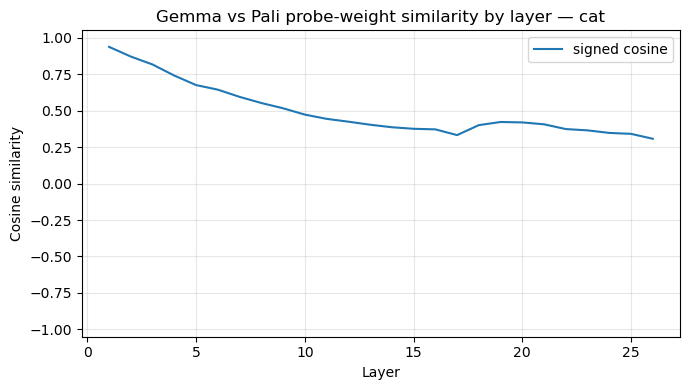

Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (800, 2304), size of gemma_labels_train: 800
size of polygemma_activations_test: (200, 2304), size of polygemma_labels_test: 200
X_train_flat shape: (800, 2304)
y_train shape: 800
X_test_flat shape: (200, 2304)
y_test shape: 200
Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (800, 2304), size of gemma_labels_train: 800
size of polygemma_activations_test: (200, 2304), size of polygemma_labels_test: 200
X_train_flat shape: (800, 2304)
y_train shape: 800
X_test_flat shape: (200, 2304)
y_test shape: 200
Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
si

/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (800, 2304), size of gemma_labels_train: 800
size of polygemma_activations_test: (200, 2304), size of polygemma_labels_test: 200
X_train_flat shape: (800, 2304)
y_train shape: 800
X_test_flat shape: (200, 2304)
y_test shape: 200
Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (800, 2304), size of gemma_labels_train: 800
size of polygemma_activations_test: (200, 2304), size of polygemma_labels_test: 200
X_train_flat shape: (800, 2304)
y_train shape: 800
X_test_flat shape: (200, 2304)
y_test shape: 200
Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
si

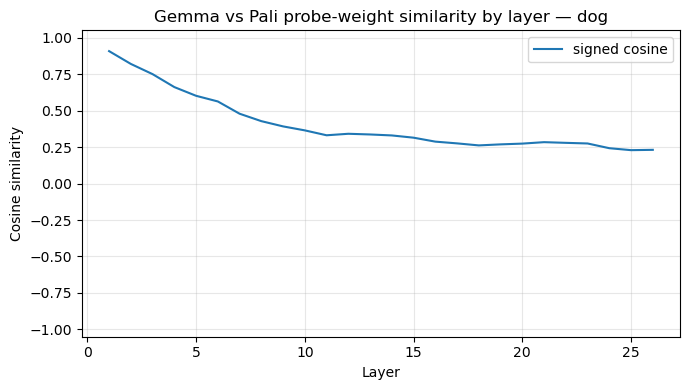

Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (800, 2304), size of gemma_labels_train: 800
size of polygemma_activations_test: (200, 2304), size of polygemma_labels_test: 200
X_train_flat shape: (800, 2304)
y_train shape: 800
X_test_flat shape: (200, 2304)
y_test shape: 200
Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (800, 2304), size of gemma_labels_train: 800
size of polygemma_activations_test: (200, 2304), size of polygemma_labels_test: 200
X_train_flat shape: (800, 2304)
y_train shape: 800
X_test_flat shape: (200, 2304)
y_test shape: 200
Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
si

/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (800, 2304), size of gemma_labels_train: 800
size of polygemma_activations_test: (200, 2304), size of polygemma_labels_test: 200
X_train_flat shape: (800, 2304)
y_train shape: 800
X_test_flat shape: (200, 2304)
y_test shape: 200
Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (800, 2304), size of gemma_labels_train: 800
size of polygemma_activations_test: (200, 2304), size of polygemma_labels_test: 200
X_train_flat shape: (800, 2304)
y_train shape: 800
X_test_flat shape: (200, 2304)
y_test shape: 200
Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
si

/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (800, 2304), size of gemma_labels_train: 800
size of polygemma_activations_test: (200, 2304), size of polygemma_labels_test: 200
X_train_flat shape: (800, 2304)
y_train shape: 800
X_test_flat shape: (200, 2304)
y_test shape: 200
Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (800, 2304), size of gemma_labels_train: 800
size of polygemma_activations_test: (200, 2304), size of polygemma_labels_test: 200
X_train_flat shape: (800, 2304)
y_train shape: 800
X_test_flat shape: (200, 2304)
y_test shape: 200
Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
si

/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (800, 2304), size of gemma_labels_train: 800
size of polygemma_activations_test: (200, 2304), size of polygemma_labels_test: 200
X_train_flat shape: (800, 2304)
y_train shape: 800
X_test_flat shape: (200, 2304)
y_test shape: 200
Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (800, 2304), size of gemma_labels_train: 800
size of polygemma_activations_test: (200, 2304), size of polygemma_labels_test: 200
X_train_flat shape: (800, 2304)
y_train shape: 800
X_test_flat shape: (200, 2304)
y_test shape: 200
Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
si

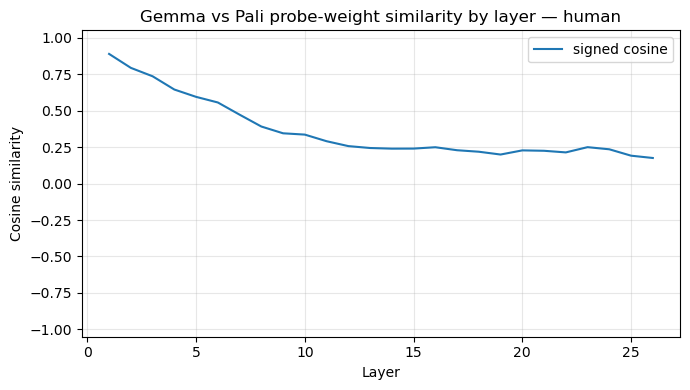

In [10]:
load_models_with_eval

# All probe exps

In [51]:
import json, numpy as np, torch
from contextlib import suppress

DROP_KEYS = {
    "model", "estimator", "clf", "classifier", "pipeline",
    "sklearn_probe", "probe", "vectorizer", "scaler", "pca",
    "figure", "fig", "axes", "ax", "roc_curve_fig", "pr_curve_fig"
}

def json_sanitize(obj, _visited=None):
    if _visited is None: _visited = set()
    oid = id(obj)
    if oid in _visited:
        return "<circular_ref>"
    _visited.add(oid)

    # Primitives
    if obj is None or isinstance(obj, (bool, int, float, str)):
        return obj

    # NumPy / torch
    if isinstance(obj, (np.integer, np.floating)):
        return obj.item()
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, torch.Tensor):
        return obj.detach().cpu().tolist()

    # Mappings
    if isinstance(obj, dict):
        out = {}
        for k, v in obj.items():
            k_str = str(k)
            if k_str in DROP_KEYS:
                continue
            out[k_str] = json_sanitize(v, _visited)
        return out

    # Sequences / Sets / Tuples
    if isinstance(obj, (list, tuple, set)):
        return [json_sanitize(v, _visited) for v in obj]

    # sklearn classification_report (string ok), others: use repr as last resort
    with suppress(Exception):
        return repr(obj)
    return str(obj)

def safe_save_results(results, path, meta=None):
    minimal = {
        "meta": meta or {},
        "sklearn": {
            "train_acc": float(results["sklearn"].get("train_acc", float("nan"))),
            "test_acc":  float(results["sklearn"].get("test_acc",  float("nan"))),
            # keep dict report if available; if it’s a string it’s also fine
            "classification_report": results["sklearn"].get("classification_report", None),
            "y_test": [int(x) for x in results["sklearn"].get("y_test", [])],
            "y_pred": [int(x) for x in results["sklearn"].get("y_pred", [])],
        }
    }
    # merge any extra *safe* fields
    sanitized = json_sanitize(results)
    minimal["extra"] = sanitized.get("extra", {})  # optional
    with open(path, "w") as f:
        json.dump(minimal, f, indent=2)



=== Precomputing activations for concept: cat ===


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


  -> computing acts for google/gemma-2-2b (layers 1..26)


Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00, 55.90it/s]


  -> computing acts for google/paligemma2-3b-pt-224 (layers 1..26)


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]



Running linear probing experiment: cat | train on gemma-2-2b → test on gemma-2-2b
[layer 01] train_acc=1.0000 | test_acc=0.9595
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 02] train_acc=1.0000 | test_acc=0.9730
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 03] train_acc=1.0000 | test_acc=0.9865
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 04] train_acc=1.0000 | test_acc=0.9595
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 05] train_acc=1.0000 | test_acc=0.9595
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 06] train_acc=1.0000 | test_acc=0.9459
(warn) safe_save_results failed: tuple indices must be integers or slices, not st

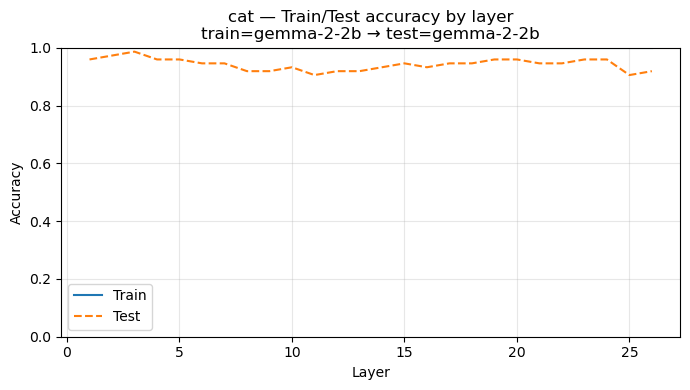


Running linear probing experiment: cat | train on gemma-2-2b → test on paligemma2-3b-pt-224
[layer 01] train_acc=1.0000 | test_acc=0.9730
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 02] train_acc=1.0000 | test_acc=0.9595
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 03] train_acc=1.0000 | test_acc=0.9730
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 04] train_acc=1.0000 | test_acc=0.9189
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 05] train_acc=1.0000 | test_acc=0.9459
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 06] train_acc=1.0000 | test_acc=0.9054
(warn) safe_save_results failed: tuple indices must be integers or slic

/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[layer 11] train_acc=1.0000 | test_acc=0.4459
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.


/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[layer 12] train_acc=1.0000 | test_acc=0.4459
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 13] train_acc=1.0000 | test_acc=0.4595
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.


/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[layer 14] train_acc=1.0000 | test_acc=0.4459
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.


/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[layer 15] train_acc=1.0000 | test_acc=0.4459
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.


/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[layer 16] train_acc=1.0000 | test_acc=0.4459
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 17] train_acc=1.0000 | test_acc=0.5811
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 18] train_acc=1.0000 | test_acc=0.5270
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 19] train_acc=1.0000 | test_acc=0.7162
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 20] train_acc=1.0000 | test_acc=0.9324
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 21] train_acc=1.0000 | test_acc=0.8784
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 22] train_acc=1.0000 | test_acc=0.7838
(warn)

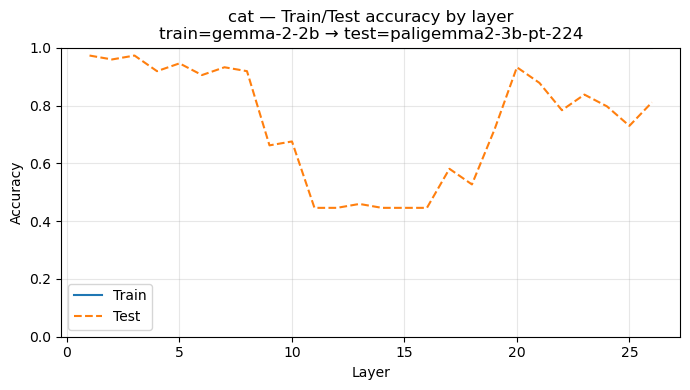


Running linear probing experiment: cat | train on paligemma2-3b-pt-224 → test on gemma-2-2b
[layer 01] train_acc=1.0000 | test_acc=0.9595
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 02] train_acc=1.0000 | test_acc=0.9865
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 03] train_acc=1.0000 | test_acc=0.9595
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 04] train_acc=1.0000 | test_acc=0.9595
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 05] train_acc=1.0000 | test_acc=0.8243
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 06] train_acc=1.0000 | test_acc=0.8514
(warn) safe_save_results failed: tuple indices must be integers or slic

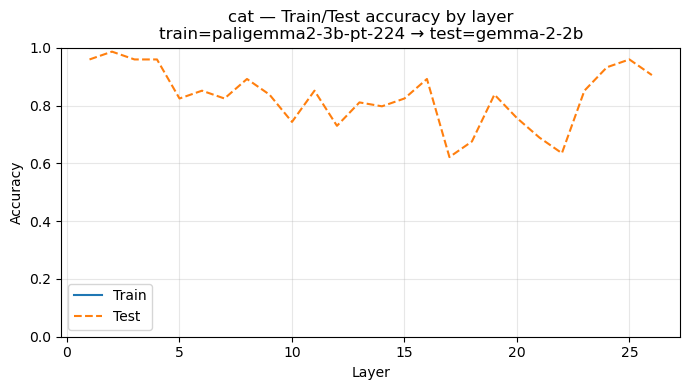


Running linear probing experiment: cat | train on paligemma2-3b-pt-224 → test on paligemma2-3b-pt-224
[layer 01] train_acc=1.0000 | test_acc=0.9595
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 02] train_acc=1.0000 | test_acc=0.9730
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 03] train_acc=1.0000 | test_acc=0.9730
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 04] train_acc=1.0000 | test_acc=0.9730
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 05] train_acc=1.0000 | test_acc=0.9595
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 06] train_acc=1.0000 | test_acc=0.9595
(warn) safe_save_results failed: tuple indices must be intege

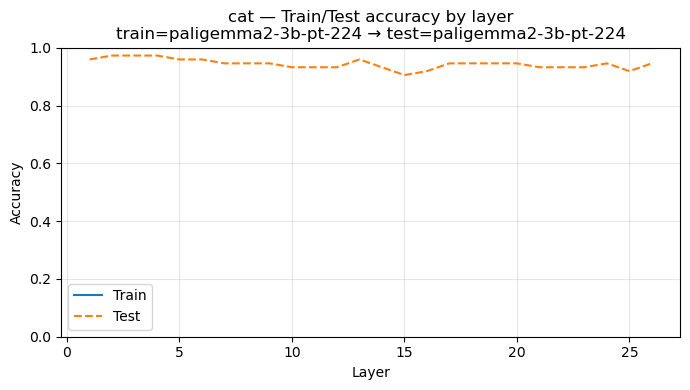


=== Precomputing activations for concept: dog ===


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


  -> computing acts for google/gemma-2-2b (layers 1..26)


Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00, 58.31it/s]


  -> computing acts for google/paligemma2-3b-pt-224 (layers 1..26)


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]



Running linear probing experiment: dog | train on gemma-2-2b → test on gemma-2-2b
[layer 01] train_acc=1.0000 | test_acc=0.8732
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 02] train_acc=1.0000 | test_acc=0.8451
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 03] train_acc=1.0000 | test_acc=0.8732
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 04] train_acc=1.0000 | test_acc=0.8732
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 05] train_acc=1.0000 | test_acc=0.8732
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 06] train_acc=1.0000 | test_acc=0.8873
(warn) safe_save_results failed: tuple indices must be integers or slices, not st

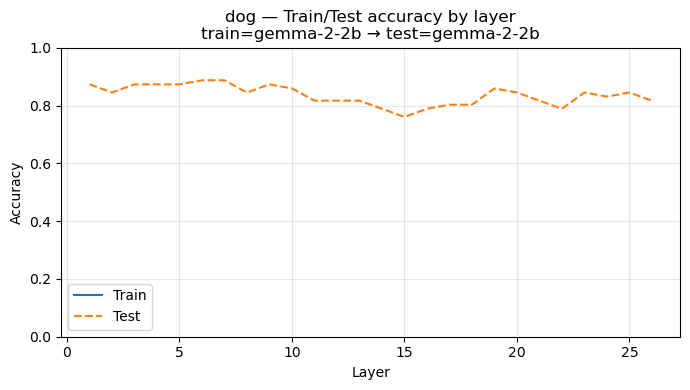


Running linear probing experiment: dog | train on gemma-2-2b → test on paligemma2-3b-pt-224
[layer 01] train_acc=1.0000 | test_acc=0.7887
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 02] train_acc=1.0000 | test_acc=0.8310
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 03] train_acc=1.0000 | test_acc=0.9014
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 04] train_acc=1.0000 | test_acc=0.8873
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 05] train_acc=1.0000 | test_acc=0.8451
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 06] train_acc=1.0000 | test_acc=0.7606
(warn) safe_save_results failed: tuple indices must be integers or slic

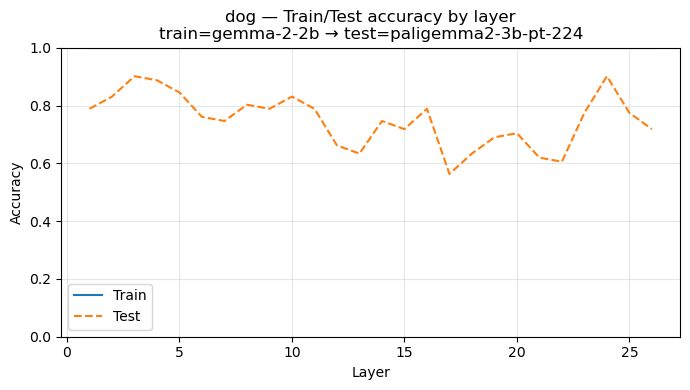


Running linear probing experiment: dog | train on paligemma2-3b-pt-224 → test on gemma-2-2b
[layer 01] train_acc=1.0000 | test_acc=0.9014
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 02] train_acc=1.0000 | test_acc=0.8873
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 03] train_acc=1.0000 | test_acc=0.9014
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 04] train_acc=1.0000 | test_acc=0.9014
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 05] train_acc=1.0000 | test_acc=0.8592
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 06] train_acc=1.0000 | test_acc=0.8310
(warn) safe_save_results failed: tuple indices must be integers or slic

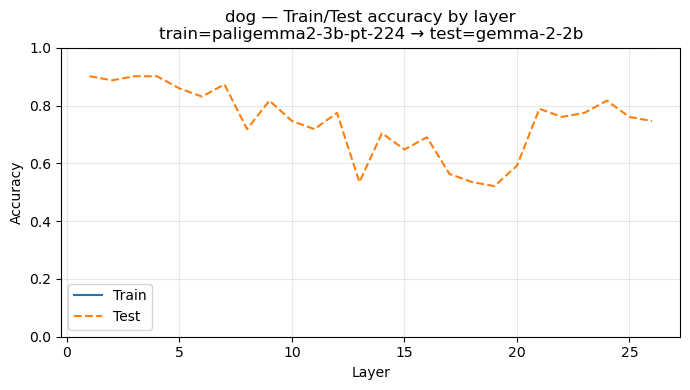


Running linear probing experiment: dog | train on paligemma2-3b-pt-224 → test on paligemma2-3b-pt-224
[layer 01] train_acc=1.0000 | test_acc=0.9014
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 02] train_acc=1.0000 | test_acc=0.8592
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 03] train_acc=1.0000 | test_acc=0.9014
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 04] train_acc=1.0000 | test_acc=0.8732
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 05] train_acc=1.0000 | test_acc=0.8732
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 06] train_acc=1.0000 | test_acc=0.8592
(warn) safe_save_results failed: tuple indices must be intege

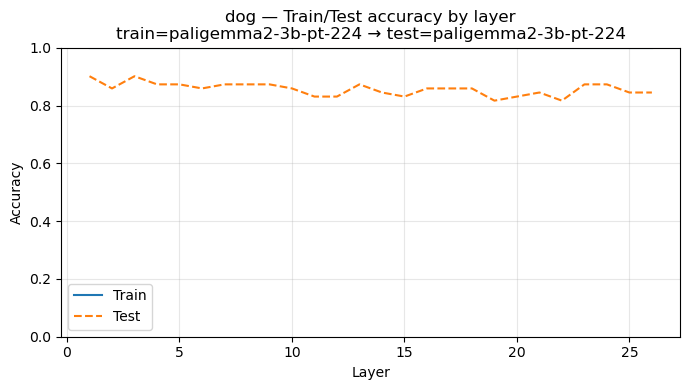


=== Precomputing activations for concept: human ===


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


  -> computing acts for google/gemma-2-2b (layers 1..26)


Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00, 55.89it/s]


  -> computing acts for google/paligemma2-3b-pt-224 (layers 1..26)


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]



Running linear probing experiment: human | train on gemma-2-2b → test on gemma-2-2b
[layer 01] train_acc=1.0000 | test_acc=0.8900
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 02] train_acc=1.0000 | test_acc=0.8600
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 03] train_acc=1.0000 | test_acc=0.8600
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 04] train_acc=1.0000 | test_acc=0.8500
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 05] train_acc=1.0000 | test_acc=0.8400
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 06] train_acc=1.0000 | test_acc=0.8450
(warn) safe_save_results failed: tuple indices must be integers or slices, not 

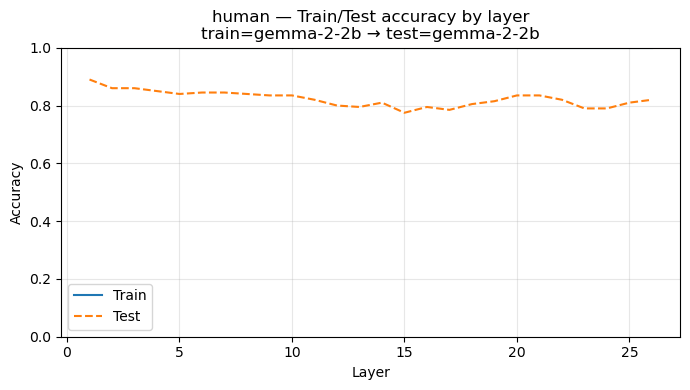


Running linear probing experiment: human | train on gemma-2-2b → test on paligemma2-3b-pt-224
[layer 01] train_acc=1.0000 | test_acc=0.8700
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 02] train_acc=1.0000 | test_acc=0.8700
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 03] train_acc=1.0000 | test_acc=0.8600
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 04] train_acc=1.0000 | test_acc=0.8300
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 05] train_acc=1.0000 | test_acc=0.7400
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 06] train_acc=1.0000 | test_acc=0.8250
(warn) safe_save_results failed: tuple indices must be integers or sl

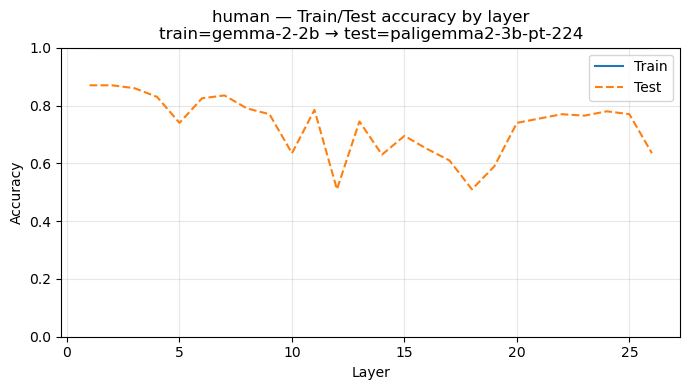


Running linear probing experiment: human | train on paligemma2-3b-pt-224 → test on gemma-2-2b
[layer 01] train_acc=1.0000 | test_acc=0.8700
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 02] train_acc=1.0000 | test_acc=0.8700
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 03] train_acc=1.0000 | test_acc=0.8600
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 04] train_acc=1.0000 | test_acc=0.7750
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 05] train_acc=1.0000 | test_acc=0.6400
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 06] train_acc=1.0000 | test_acc=0.7950
(warn) safe_save_results failed: tuple indices must be integers or sl

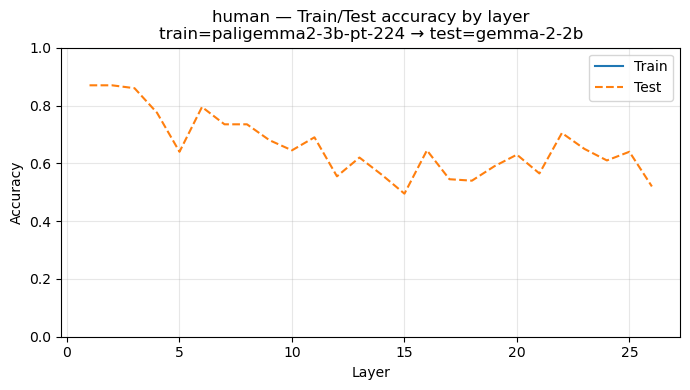


Running linear probing experiment: human | train on paligemma2-3b-pt-224 → test on paligemma2-3b-pt-224
[layer 01] train_acc=1.0000 | test_acc=0.8550
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 02] train_acc=1.0000 | test_acc=0.8850
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 03] train_acc=1.0000 | test_acc=0.8750
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 04] train_acc=1.0000 | test_acc=0.8600
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 05] train_acc=1.0000 | test_acc=0.8600
(warn) safe_save_results failed: tuple indices must be integers or slices, not str. Writing ultra-minimal JSON.
[layer 06] train_acc=1.0000 | test_acc=0.8650
(warn) safe_save_results failed: tuple indices must be inte

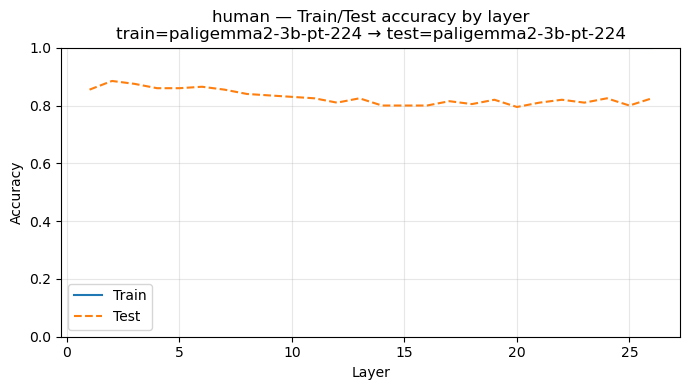

In [52]:
import os, gc, io, json
from contextlib import redirect_stdout

import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

# -----------------------------
# Precompute pooled activations
# ----------------------------

def _amp_ctx(device, use_amp=True):
    """Return a context manager for autocast if on CUDA, else a no-op."""
    if not use_amp:
        return nullcontext()
    is_cuda = torch.cuda.is_available() and (
        str(device).startswith("cuda") or getattr(getattr(device, "type", None), "__str__", lambda: "")() == "cuda"
        or (hasattr(device, "type") and device.type == "cuda")
    )
    if not is_cuda:
        return nullcontext()
    # Prefer new API if available
    try:
        return torch.autocast("cuda", dtype=torch.float16)
    except Exception:
        # Fallback for older PyTorch
        return torch.cuda.amp.autocast(dtype=torch.float16)

    
def precompute_pooled_activations(
    model, tokenizer, texts, layers, device,
    batch_size=8, pool="mean", max_length=256, use_amp=True
):
    model.eval()
    acts = {l: [] for l in layers}

    with torch.inference_mode(), _amp_ctx(device, use_amp):
        for start in range(0, len(texts), batch_size):
            batch_texts = texts[start:start+batch_size]
            enc = tokenizer(
                batch_texts, return_tensors="pt",
                padding=True, truncation=True, max_length=max_length
            )
            enc = {k: v.to(device) for k, v in enc.items()}

            out = model(**enc, output_hidden_states=True, return_dict=True)
            hs_tuple = out.hidden_states  # (emb, layer1, ..., layerL)

            mask = enc["attention_mask"].unsqueeze(-1)  # (B,T,1)
            for l in layers:
                hs = hs_tuple[l]  # (B,T,D)
                if pool == "cls":
                    pooled = hs[:, 0, :]
                elif pool == "last":
                    last_idx = (enc["attention_mask"].sum(dim=1)-1).clamp(min=0)
                    pooled = hs[torch.arange(hs.size(0), device=hs.device), last_idx, :]
                else:  # mean
                    summed = (hs * mask).sum(dim=1)
                    denom  = mask.sum(dim=1).clamp(min=1)
                    pooled = summed / denom

                acts[l].append(pooled.detach().cpu().numpy())

            del out, hs_tuple, enc
            torch.cuda.empty_cache()

    acts = {l: np.concatenate(chunks, axis=0) for l, chunks in acts.items()}
    return acts


# -----------------------------------------
# Utility: load -> precompute -> unload
# -----------------------------------------
def compute_acts_for_model_name(model_name, texts, layers, device):
    model = load_models_with_eval(model_name, device)
    if "pali" not in model_name:
        tok = AutoTokenizer.from_pretrained("google/paligemma2-3b-pt-224", use_fast=True)
    else:
        tok = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    acts = precompute_pooled_activations(model, tok, texts, layers, device)
    # derive feature dim for sanity checks
    any_layer = layers[0]
    feat_dim = acts[any_layer].shape[1]
    # free VRAM
    del model, tok
    gc.collect()
    torch.cuda.empty_cache()
    return acts, feat_dim

# -----------------------------------------
# MAIN
# -----------------------------------------
model1_names = ["google/gemma-2-2b", "google/paligemma2-3b-pt-224"]
model2_names = ["google/gemma-2-2b", "google/paligemma2-3b-pt-224"]
data_name_list = ['cat', 'dog', 'human']

# Decide layers safely (take min across all models)
# (We’ll pull num_hidden_layers from the first time each model is loaded.)
# To avoid loading twice, we’ll compute activations right away per model.
for texts, labels, data_name in zip(texts_list, labels_list, data_name_list):
    print(f"\n=== Precomputing activations for concept: {data_name} ===", flush=True)

    # Figure out which models we need for this concept
    needed_models = sorted(set(model1_names + model2_names))

    # Decide a shared layer list AFTER we’ve inspected all model configs
    # Strategy: compute acts per model one-by-one, track each model's L and cache acts.
    acts_cache = {}
    feat_dims  = {}
    max_layers_by_model = {}

    # We’ll read num_hidden_layers from config after loading; then save acts & unload model.
    for mname in needed_models:
        # Load once, grab num layers, compute acts, unload
        tmp_model = load_models_with_eval(mname, DEVICE_1)
        num_layers = int(getattr(tmp_model.config, "num_hidden_layers", 26))
        del tmp_model
        gc.collect()
        torch.cuda.empty_cache()
        max_layers_by_model[mname] = num_layers

    # shared 1..L across all models
    layer_to_test = list(range(1, min(max_layers_by_model.values()) + 1))

    # Now compute & cache acts per model (sequentially to save memory)
    for mname in needed_models:
        print(f"  -> computing acts for {mname} (layers {layer_to_test[0]}..{layer_to_test[-1]})", flush=True)
        acts_cache[mname], feat_dims[mname] = compute_acts_for_model_name(
            mname, texts, layer_to_test, DEVICE_1
        )

    # Cross-model experiments
    for model1_name in model1_names:
        for model2_name in model2_names:
            print(f"\nRunning linear probing experiment: {data_name} | train on {model1_name.split('/')[-1]} → test on {model2_name.split('/')[-1]}", flush=True)

            all_results = []
            train_accs, test_accs = [], []

            # Optional: if feature dims mismatch, reduce both to the shared min-dim via PCA
            d1, d2 = feat_dims[model1_name], feat_dims[model2_name]
            shared_d = min(d1, d2)
            use_pca = (d1 != d2)

            if use_pca:
                from sklearn.decomposition import PCA

            for layer in layer_to_test:
                X_train = acts_cache[model1_name][layer]  # (N, d1)
                X_test  = acts_cache[model2_name][layer]  # (N, d2)

                if use_pca:
                    # Fit PCA on TRAIN only, transform both to shared_d
                    pca = PCA(n_components=shared_d, svd_solver="auto", random_state=0)
                    X_train_reduced = pca.fit_transform(X_train)
                    X_test_reduced  = pca.transform(X_test)
                else:
                    X_train_reduced, X_test_reduced = X_train, X_test

                # === Run probe experiment ===
                # Suppress inner prints if run_experiment is verbose
                with redirect_stdout(io.StringIO()):
                    results = experiment.run_experiment(
                        X_train_reduced, labels,
                        X_test_reduced,  labels
                    )

                all_results.append(results)

                # Console summary
                tr = results[1]['sklearn']['train_acc']
                te = results[1]['sklearn']['test_acc']
                train_accs.append(tr); test_accs.append(te)
                print(f"[layer {layer:02d}] train_acc={tr:.4f} | test_acc={te:.4f}")

                # Save per-layer JSON
                os.makedirs(f"../output/{data_name}", exist_ok=True)
                tag = f"{model1_name.split('/')[-1]}_{model2_name.split('/')[-1]}"
                save_path = f"../output/{data_name}/linear_probing_results_{layer}_{tag}.json"
                meta = {"data": data_name, "layer": layer,
                        "train_model": model1_name, "test_model": model2_name}
                try:
                    safe_save_results(results, save_path, meta=meta)
                except Exception as e:
                    print(f"(warn) safe_save_results failed: {e}. Writing ultra-minimal JSON.")
                    ultra = {
                        "meta": meta,
                        "train_acc": float(results[1]["sklearn"]["train_acc"]),
                        "test_acc":  float(results[1]["sklearn"]["test_acc"])
                    }
                    with open(save_path.replace(".json", "_minimal.json"), "w") as f:
                        json.dump(ultra, f, indent=2)


                # free per-iteration temps
                del X_train_reduced, X_test_reduced, results
                gc.collect()
                torch.cuda.empty_cache()

            # ===== Plot Train and Test Accuracy Across Layers =====
            layers = layer_to_test
            plt.figure(figsize=(7, 4))
            plt.plot(layers, train_accs, label='Train')
            plt.plot(layers, test_accs,  label='Test', linestyle="--")
            plt.xlabel('Layer'); plt.ylabel('Accuracy')
            plt.title(f"{data_name} — Train/Test accuracy by layer\ntrain={model1_name.split('/')[-1]} → test={model2_name.split('/')[-1]}")
            plt.ylim(0.0, 1.0); plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
            os.makedirs(f"../figs_tabs/{data_name}/", exist_ok=True)
            plt.savefig(f"../figs_tabs/{data_name}/acc_by_layer_{model1_name.split('/')[-1]}_{model2_name.split('/')[-1]}.png", dpi=200)
            plt.show()
            plt.close()

    # Clear cached activations for this concept to free RAM
    del acts_cache
    gc.collect()
    torch.cuda.empty_cache()


In [ ]:
# load models
model1_names = ["google/gemma-2-2b", "google/paligemma2-3b-pt-224"]
model2_names = ["google/gemma-2-2b", "google/paligemma2-3b-pt-224"]
data_name_list = ['cat', 'dog', 'human']
for texts, labels, data_name in zip(texts_list, labels_list, data_name_list):
    for model1_name in model1_names:
        for model2_name in model2_names:

            model1 = load_models_with_eval(model1_name, DEVICE_1)
            model2 = load_models_with_eval(model2_name, DEVICE_2)

            # # Dummy activations (replace with real data)
            # gemma_activations = np.random.randn(1000, 768)  # 1000 samples, 768 dims
            # gemma_labels = np.random.randint(0, 2, 1000)    # binary cat/dog labels

            # polygemma_activations = np.random.randn(200, 768)  # 200 test samples
            # polygemma_labels = np.random.randint(0, 2, 200)

            layer_to_test = list(range(1, 27))
            all_results = []
            # Run experiment per layer
            for layer in layer_to_test:
                # Produce activation-label pairs
                with torch.inference_mode():
                    model1_activations = get_acts(model1, texts, layer, model1_name, DEVICE_1)
                    model2_activations = get_acts(model2, texts, layer, model2_name, DEVICE_2)

                # === Run probe experiment ===
                results = experiment.run_experiment(
                    model1_activations, labels,
                    model2_activations, labels
                )
    
                all_results.append(results)

                print(f"\n=== LAYER {layer} RESULTS ===")
                print(f"Train Accuracy: {results['sklearn']['train_acc']:.4f}")
                print(f"Test Accuracy: {results['sklearn']['test_acc']:.4f}")
                print("Classification Report:")
                print(results['sklearn']['classification_report'])
                      
                 
                      
                # Save results
                os.makedirs(f"../output/{data_name}", exist_ok=True)
                experiment.save_results(results, f"../output/{data_name}/linear_probing_results_{layer}_{model1_name.split('/')[-1]}_{model2_name.split('/')[-1]}.json")

                # Save misclassified examples
                if 'y_test' in results['sklearn'] and 'y_pred' in results['sklearn']:
                    mis_indices = [i for i, (yt, yp) in enumerate(zip(
                        results['sklearn']['y_test'], results['sklearn']['y_pred']
                    )) if yt != yp]
                    mis_info = [
                        {
                            'text': cat_texts[i],  # assuming you meant cat_texts not text
                            'true_label': int(results['sklearn']['y_test'][i]),
                            'pred_label': int(results['sklearn']['y_pred'][i])
                        }
                        for i in mis_indices
                    ]
                    os.makedirs(f"../output/{data_name}/{model1_name.split('/')[-1]}_{model2_name.split('/')[-1]}", exist_ok=True)
                    with open(f"../output/{data_name}/{model1_name.split('/')[-1]}_{model2_name.split('/')[-1]}/misclassified_layer_{layer}.json", 'w') as f:
                        json.dump(mis_info, f, indent=2)
                else:
                    print("Warning: 'y_test' or 'y_pred' not found in results; misclassifications not saved.")

                del model1_activations, model2_activations, results
                gc.collect()
                torch.cuda.empty_cache()

            # ===== Plot Train and Test Accuracy Across Layers =====

            layers = layer_to_test
            train_accs = [res['sklearn']['train_acc'] for res in all_results]
            test_accs = [res['sklearn']['test_acc'] for res in all_results]

            plt.figure()
            plt.plot(layers, train_accs)
            plt.plot(layers, test_accs)
            plt.xlabel('Layer')
            plt.ylabel('Accuracy')
            plt.title(f"Train and Test Accuracy by Layer_{model1_name.split('/')[-1]}_{model2_name.split('/')[-1]}. Concept: {data_name}")
            plt.legend(['Train', 'Test'])
            os.makedirs(f"../figs_tabs/{data_name}/", exist_ok=True)
            plt.savefig(f"../figs_tabs/{data_name}/Linear Probe Train and Test Accuracy by Layer_{model1_name.split('/')[-1]}_{model2_name.split('/')[-1]}.png")
            plt.show()



# All exps (image to pali)

In [40]:
# # NEW imports (top of file)
# from contextlib import nullcontext
# from PIL import Image
# from transformers import AutoProcessor
# import concurrent.futures

# # NEW: preload compressed image bytes into RAM once per dataset
# def _read_bytes(path: str) -> bytes:
#     with open(path, "rb") as f:
#         return f.read()

# def preload_image_bytes(filenames, root, max_workers: int = 12):
#     paths = [os.path.join(root, fn) for fn in filenames]
#     with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as ex:
#         data = list(ex.map(_read_bytes, paths))
#     return dict(zip(filenames, data))
# # NEW imports (top of file)
# from contextlib import nullcontext
# from PIL import Image
# from transformers import AutoProcessor
# import concurrent.futures

# # NEW: preload compressed image bytes into RAM once per dataset
# def _read_bytes(path: str) -> bytes:
#     with open(path, "rb") as f:
#         return f.read()

# def preload_image_bytes(filenames, root, max_workers: int = 12):
#     paths = [os.path.join(root, fn) for fn in filenames]
#     with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as ex:
#         data = list(ex.map(_read_bytes, paths))
#     return dict(zip(filenames, data))

# def compute_acts_for_model_name(
#     model_name, texts, layers, device,
#     img_filenames=None, img_byte_cache=None, pool="mean"
# ):
#     model = load_models_with_eval(model_name, device)

#     if "pali" in model_name.lower():
#         preproc = AutoProcessor.from_pretrained(model_name)
#         acts = precompute_pooled_activations(
#             model, preproc, texts, layers, device,
#             pool=pool, is_pali=True,
#             img_filenames=img_filenames, img_byte_cache=img_byte_cache
#         )
#         any_layer = layers[0]; feat_dim = acts[any_layer].shape[1]
#         del model, preproc
#     else:
#         tok = AutoTokenizer.from_pretrained(model_name, use_fast=True)
#         acts = precompute_pooled_activations(
#             model, tok, texts, layers, device, pool=pool
#         )
#         any_layer = layers[0]; feat_dim = acts[any_layer].shape[1]
#         del model, tok

#     gc.collect(); torch.cuda.empty_cache()
#     return acts, feat_dim



# # Figure out max layers per model (decoder for Gemma, VISION for PaliGemma)
# for mname in needed_models:
#     tmp_model = load_models_with_eval(mname, DEVICE_1)
#     if "pali" in mname.lower():
#         num_layers = int(getattr(tmp_model.vision_tower.config, "num_hidden_layers",
#                           getattr(tmp_model.vision_tower.config, "num_layers", 24)))
#     else:
#         num_layers = int(getattr(tmp_model.config, "num_hidden_layers", 26))
#     del tmp_model
#     gc.collect()
#     torch.cuda.empty_cache()
#     max_layers_by_model[mname] = num_layers

# layer_to_test = list(range(1, min(max_layers_by_model.values()) + 1))

# IMG_ROOT =  f"../data/coco_val2017_{data_name}_binary_with_captions_balanced_images" 

# for texts, labels, data_name, filenames in zip(texts_list, labels_list, data_name_list, filenames_list):
#     print(f"\n=== Precomputing activations for concept: {data_name} ===", flush=True)

#     # Build one byte cache per dataset (reused across models)
#     img_byte_cache = preload_image_bytes(filenames, IMG_ROOT, max_workers=12)

#     needed_models = sorted(set(model1_names + model2_names))
#     acts_cache = {}
#     feat_dims  = {}
#     max_layers_by_model = {}

#     # (layer discovery block from Section 4 here)

#     # Now compute & cache acts per model
#     for mname in needed_models:
#         print(f"  -> computing acts for {mname} (layers {layer_to_test[0]}..{layer_to_test[-1]})", flush=True)
#         if "pali" in mname.lower():
#             acts_cache[mname], feat_dims[mname] = compute_acts_for_model_name(
#                 mname, texts=None, layers=layer_to_test, device=DEVICE_1,
#                 img_filenames=filenames, img_byte_cache=img_byte_cache, pool="mean"
#             )
#         else:
#             acts_cache[mname], feat_dims[mname] = compute_acts_for_model_name(
#                 mname, texts=texts, layers=layer_to_test, device=DEVICE_1, pool="mean"
#             )

#     # ... the rest of your cross-model experiment loop stays unchanged ...


NameError: name 'needed_models' is not defined


=== Concept: cat ===

Running linear probe: cat | train on gemma-2-2b → test on gemma-2-2b


Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00, 57.78it/s]


Running linear probing experiment: cat_dog_classification
Gemma training data: (368, 2304)
PolyGemma test data: (368, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (294, 2304), size of gemma_labels_train: 294
size of polygemma_activations_test: (74, 2304), size of polygemma_labels_test: 74
X_train_flat shape: (294, 2304)
y_train shape: 294
X_test_flat shape: (74, 2304)
y_test shape: 74
[cat] layer 01 | train_acc=1.0000 | test_acc=0.9595
(warn) save_results failed (Circular reference detected); writing minimal JSON.
Running linear probing experiment: cat_dog_classification
Gemma training data: (368, 2304)
PolyGemma test data: (368, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (294, 2304), size of gemma_labels_train: 294
size of polygemma_activations_test: (74, 2304), size of polygemma_labels_test: 74
X_train_flat shape: (294, 2304)
y_train shape: 294
X_test_flat shape: (74, 2304)
y_test shape: 74
[cat] layer 02 | train_acc=1.0000 | test

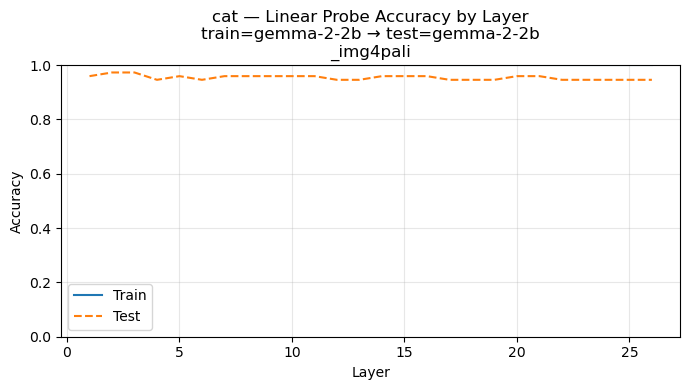


Running linear probe: cat | train on gemma-2-2b → test on paligemma2-3b-pt-224


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


Running linear probing experiment: cat_dog_classification
Gemma training data: (368, 2304)
PolyGemma test data: (368, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (294, 2304), size of gemma_labels_train: 294
size of polygemma_activations_test: (74, 2304), size of polygemma_labels_test: 74
X_train_flat shape: (294, 2304)
y_train shape: 294
X_test_flat shape: (74, 2304)
y_test shape: 74
[cat] layer 01 | train_acc=1.0000 | test_acc=0.9730
(warn) save_results failed (Circular reference detected); writing minimal JSON.
Running linear probing experiment: cat_dog_classification
Gemma training data: (368, 2304)
PolyGemma test data: (368, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (294, 2304), size of gemma_labels_train: 294
size of polygemma_activations_test: (74, 2304), size of polygemma_labels_test: 74
X_train_flat shape: (294, 2304)
y_train shape: 294
X_test_flat shape: (74, 2304)
y_test shape: 74
[cat] layer 02 | train_acc=1.0000 | test

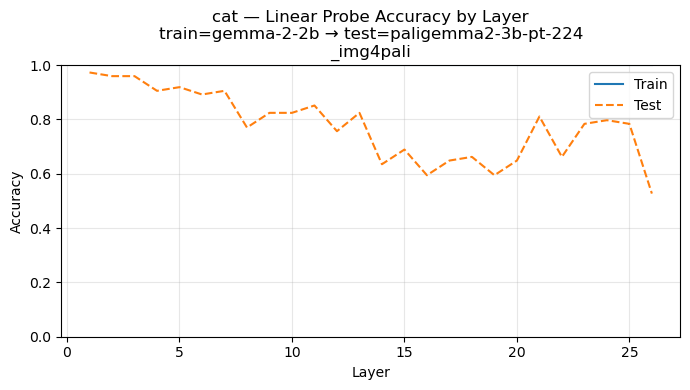


Running linear probe: cat | train on paligemma2-3b-pt-224 → test on gemma-2-2b


Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00, 56.99it/s]


Running linear probing experiment: cat_dog_classification
Gemma training data: (368, 2304)
PolyGemma test data: (368, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (294, 2304), size of gemma_labels_train: 294
size of polygemma_activations_test: (74, 2304), size of polygemma_labels_test: 74
X_train_flat shape: (294, 2304)
y_train shape: 294
X_test_flat shape: (74, 2304)
y_test shape: 74
[cat] layer 01 | train_acc=1.0000 | test_acc=0.6351
(warn) save_results failed (Circular reference detected); writing minimal JSON.
Running linear probing experiment: cat_dog_classification
Gemma training data: (368, 2304)
PolyGemma test data: (368, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (294, 2304), size of gemma_labels_train: 294
size of polygemma_activations_test: (74, 2304), size of polygemma_labels_test: 74
X_train_flat shape: (294, 2304)
y_train shape: 294
X_test_flat shape: (74, 2304)
y_test shape: 74
[cat] layer 02 | train_acc=1.0000 | test

/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Running linear probing experiment: cat_dog_classification
Gemma training data: (368, 2304)
PolyGemma test data: (368, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (294, 2304), size of gemma_labels_train: 294
size of polygemma_activations_test: (74, 2304), size of polygemma_labels_test: 74
X_train_flat shape: (294, 2304)
y_train shape: 294
X_test_flat shape: (74, 2304)
y_test shape: 74
[cat] layer 09 | train_acc=1.0000 | test_acc=0.7162
(warn) save_results failed (Circular reference detected); writing minimal JSON.
Running linear probing experiment: cat_dog_classification
Gemma training data: (368, 2304)
PolyGemma test data: (368, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (294, 2304), size of gemma_labels_train: 294
size of polygemma_activations_test: (74, 2304), size of polygemma_labels_test: 74
X_train_flat shape: (294, 2304)
y_train shape: 294
X_test_flat shape: (74, 2304)
y_test shape: 74
[cat] layer 10 | train_acc=1.0000 | test

/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Running linear probing experiment: cat_dog_classification
Gemma training data: (368, 2304)
PolyGemma test data: (368, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (294, 2304), size of gemma_labels_train: 294
size of polygemma_activations_test: (74, 2304), size of polygemma_labels_test: 74
X_train_flat shape: (294, 2304)
y_train shape: 294
X_test_flat shape: (74, 2304)
y_test shape: 74
[cat] layer 11 | train_acc=1.0000 | test_acc=0.9054
(warn) save_results failed (Circular reference detected); writing minimal JSON.
Running linear probing experiment: cat_dog_classification
Gemma training data: (368, 2304)
PolyGemma test data: (368, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (294, 2304), size of gemma_labels_train: 294
size of polygemma_activations_test: (74, 2304), size of polygemma_labels_test: 74
X_train_flat shape: (294, 2304)
y_train shape: 294
X_test_flat shape: (74, 2304)
y_test shape: 74
[cat] layer 12 | train_acc=1.0000 | test

/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Running linear probing experiment: cat_dog_classification
Gemma training data: (368, 2304)
PolyGemma test data: (368, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (294, 2304), size of gemma_labels_train: 294
size of polygemma_activations_test: (74, 2304), size of polygemma_labels_test: 74
X_train_flat shape: (294, 2304)
y_train shape: 294
X_test_flat shape: (74, 2304)
y_test shape: 74
[cat] layer 13 | train_acc=1.0000 | test_acc=0.4459
(warn) save_results failed (Circular reference detected); writing minimal JSON.


/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Running linear probing experiment: cat_dog_classification
Gemma training data: (368, 2304)
PolyGemma test data: (368, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (294, 2304), size of gemma_labels_train: 294
size of polygemma_activations_test: (74, 2304), size of polygemma_labels_test: 74
X_train_flat shape: (294, 2304)
y_train shape: 294
X_test_flat shape: (74, 2304)
y_test shape: 74
[cat] layer 14 | train_acc=1.0000 | test_acc=0.8919
(warn) save_results failed (Circular reference detected); writing minimal JSON.
Running linear probing experiment: cat_dog_classification
Gemma training data: (368, 2304)
PolyGemma test data: (368, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (294, 2304), size of gemma_labels_train: 294
size of polygemma_activations_test: (74, 2304), size of polygemma_labels_test: 74
X_train_flat shape: (294, 2304)
y_train shape: 294
X_test_flat shape: (74, 2304)
y_test shape: 74
[cat] layer 15 | train_acc=1.0000 | test

/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Running linear probing experiment: cat_dog_classification
Gemma training data: (368, 2304)
PolyGemma test data: (368, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (294, 2304), size of gemma_labels_train: 294
size of polygemma_activations_test: (74, 2304), size of polygemma_labels_test: 74
X_train_flat shape: (294, 2304)
y_train shape: 294
X_test_flat shape: (74, 2304)
y_test shape: 74
[cat] layer 17 | train_acc=1.0000 | test_acc=0.5541
(warn) save_results failed (Circular reference detected); writing minimal JSON.


/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Running linear probing experiment: cat_dog_classification
Gemma training data: (368, 2304)
PolyGemma test data: (368, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (294, 2304), size of gemma_labels_train: 294
size of polygemma_activations_test: (74, 2304), size of polygemma_labels_test: 74
X_train_flat shape: (294, 2304)
y_train shape: 294
X_test_flat shape: (74, 2304)
y_test shape: 74
[cat] layer 18 | train_acc=1.0000 | test_acc=0.5946
(warn) save_results failed (Circular reference detected); writing minimal JSON.
Running linear probing experiment: cat_dog_classification
Gemma training data: (368, 2304)
PolyGemma test data: (368, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (294, 2304), size of gemma_labels_train: 294
size of polygemma_activations_test: (74, 2304), size of polygemma_labels_test: 74
X_train_flat shape: (294, 2304)
y_train shape: 294
X_test_flat shape: (74, 2304)
y_test shape: 74
[cat] layer 19 | train_acc=1.0000 | test

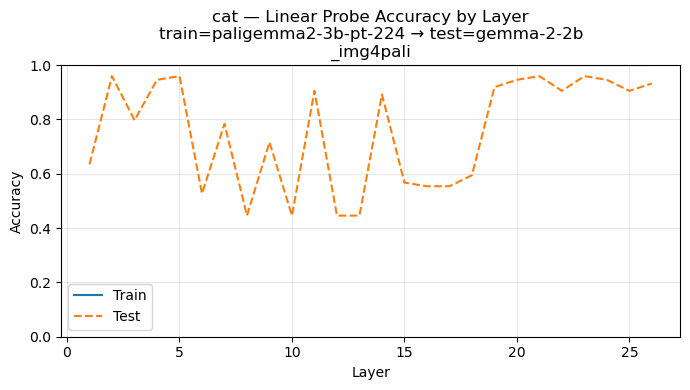


Running linear probe: cat | train on paligemma2-3b-pt-224 → test on paligemma2-3b-pt-224


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


Running linear probing experiment: cat_dog_classification
Gemma training data: (368, 2304)
PolyGemma test data: (368, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (294, 2304), size of gemma_labels_train: 294
size of polygemma_activations_test: (74, 2304), size of polygemma_labels_test: 74
X_train_flat shape: (294, 2304)
y_train shape: 294
X_test_flat shape: (74, 2304)
y_test shape: 74
[cat] layer 01 | train_acc=1.0000 | test_acc=0.9595
(warn) save_results failed (Circular reference detected); writing minimal JSON.
Running linear probing experiment: cat_dog_classification
Gemma training data: (368, 2304)
PolyGemma test data: (368, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (294, 2304), size of gemma_labels_train: 294
size of polygemma_activations_test: (74, 2304), size of polygemma_labels_test: 74
X_train_flat shape: (294, 2304)
y_train shape: 294
X_test_flat shape: (74, 2304)
y_test shape: 74
[cat] layer 02 | train_acc=1.0000 | test

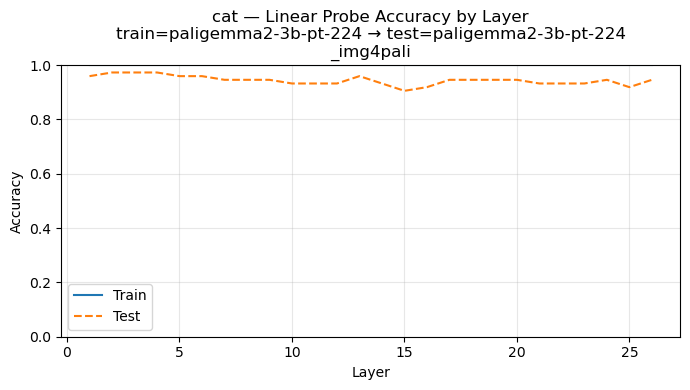


=== Concept: dog ===

Running linear probe: dog | train on gemma-2-2b → test on gemma-2-2b


Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00, 56.67it/s]


Running linear probing experiment: cat_dog_classification
Gemma training data: (354, 2304)
PolyGemma test data: (354, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (283, 2304), size of gemma_labels_train: 283
size of polygemma_activations_test: (71, 2304), size of polygemma_labels_test: 71
X_train_flat shape: (283, 2304)
y_train shape: 283
X_test_flat shape: (71, 2304)
y_test shape: 71
[dog] layer 01 | train_acc=1.0000 | test_acc=0.9014
(warn) save_results failed (Circular reference detected); writing minimal JSON.
Running linear probing experiment: cat_dog_classification
Gemma training data: (354, 2304)
PolyGemma test data: (354, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (283, 2304), size of gemma_labels_train: 283
size of polygemma_activations_test: (71, 2304), size of polygemma_labels_test: 71
X_train_flat shape: (283, 2304)
y_train shape: 283
X_test_flat shape: (71, 2304)
y_test shape: 71
[dog] layer 02 | train_acc=1.0000 | test

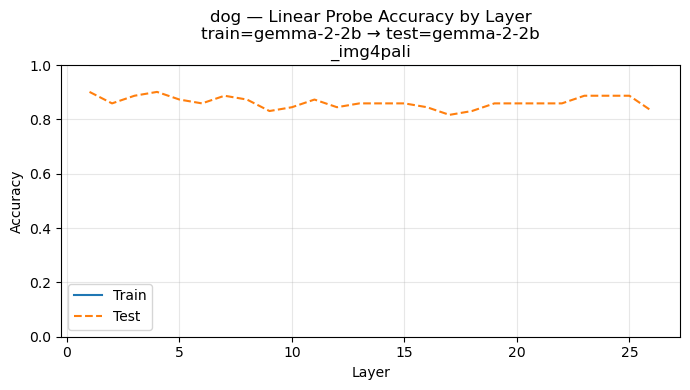


Running linear probe: dog | train on gemma-2-2b → test on paligemma2-3b-pt-224


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Running linear probing experiment: cat_dog_classification
Gemma training data: (354, 2304)
PolyGemma test data: (354, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (283, 2304), size of gemma_labels_train: 283
size of polygemma_activations_test: (71, 2304), size of polygemma_labels_test: 71
X_train_flat shape: (283, 2304)
y_train shape: 283
X_test_flat shape: (71, 2304)
y_test shape: 71
[dog] layer 01 | train_acc=1.0000 | test_acc=0.6901
(warn) save_results failed (Circular reference detected); writing minimal JSON.
Running linear probing experiment: cat_dog_classification
Gemma training data: (354, 2304)
PolyGemma test data: (354, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (283, 2304), size of gemma_labels_train: 283
size of polygemma_activations_test: (71, 2304), size of polygemma_labels_test: 71
X_train_flat shape: (283, 2304)
y_train shape: 283
X_test_flat shape: (71, 2304)
y_test shape: 71
[dog] layer 02 | train_acc=1.0000 | test

/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Running linear probing experiment: cat_dog_classification
Gemma training data: (354, 2304)
PolyGemma test data: (354, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (283, 2304), size of gemma_labels_train: 283
size of polygemma_activations_test: (71, 2304), size of polygemma_labels_test: 71
X_train_flat shape: (283, 2304)
y_train shape: 283
X_test_flat shape: (71, 2304)
y_test shape: 71
[dog] layer 04 | train_acc=1.0000 | test_acc=0.6620
(warn) save_results failed (Circular reference detected); writing minimal JSON.
Running linear probing experiment: cat_dog_classification
Gemma training data: (354, 2304)
PolyGemma test data: (354, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (283, 2304), size of gemma_labels_train: 283
size of polygemma_activations_test: (71, 2304), size of polygemma_labels_test: 71
X_train_flat shape: (283, 2304)
y_train shape: 283
X_test_flat shape: (71, 2304)
y_test shape: 71
[dog] layer 05 | train_acc=1.0000 | test

/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Running linear probing experiment: cat_dog_classification
Gemma training data: (354, 2304)
PolyGemma test data: (354, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (283, 2304), size of gemma_labels_train: 283
size of polygemma_activations_test: (71, 2304), size of polygemma_labels_test: 71
X_train_flat shape: (283, 2304)
y_train shape: 283
X_test_flat shape: (71, 2304)
y_test shape: 71
[dog] layer 16 | train_acc=1.0000 | test_acc=0.4930
(warn) save_results failed (Circular reference detected); writing minimal JSON.


/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Running linear probing experiment: cat_dog_classification
Gemma training data: (354, 2304)
PolyGemma test data: (354, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (283, 2304), size of gemma_labels_train: 283
size of polygemma_activations_test: (71, 2304), size of polygemma_labels_test: 71
X_train_flat shape: (283, 2304)
y_train shape: 283
X_test_flat shape: (71, 2304)
y_test shape: 71
[dog] layer 17 | train_acc=1.0000 | test_acc=0.4930
(warn) save_results failed (Circular reference detected); writing minimal JSON.


/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Running linear probing experiment: cat_dog_classification
Gemma training data: (354, 2304)
PolyGemma test data: (354, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (283, 2304), size of gemma_labels_train: 283
size of polygemma_activations_test: (71, 2304), size of polygemma_labels_test: 71
X_train_flat shape: (283, 2304)
y_train shape: 283
X_test_flat shape: (71, 2304)
y_test shape: 71
[dog] layer 18 | train_acc=1.0000 | test_acc=0.4930
(warn) save_results failed (Circular reference detected); writing minimal JSON.


/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Running linear probing experiment: cat_dog_classification
Gemma training data: (354, 2304)
PolyGemma test data: (354, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (283, 2304), size of gemma_labels_train: 283
size of polygemma_activations_test: (71, 2304), size of polygemma_labels_test: 71
X_train_flat shape: (283, 2304)
y_train shape: 283
X_test_flat shape: (71, 2304)
y_test shape: 71
[dog] layer 19 | train_acc=1.0000 | test_acc=0.5493
(warn) save_results failed (Circular reference detected); writing minimal JSON.
Running linear probing experiment: cat_dog_classification
Gemma training data: (354, 2304)
PolyGemma test data: (354, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (283, 2304), size of gemma_labels_train: 283
size of polygemma_activations_test: (71, 2304), size of polygemma_labels_test: 71
X_train_flat shape: (283, 2304)
y_train shape: 283
X_test_flat shape: (71, 2304)
y_test shape: 71
[dog] layer 20 | train_acc=1.0000 | test

/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Running linear probing experiment: cat_dog_classification
Gemma training data: (354, 2304)
PolyGemma test data: (354, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (283, 2304), size of gemma_labels_train: 283
size of polygemma_activations_test: (71, 2304), size of polygemma_labels_test: 71
X_train_flat shape: (283, 2304)
y_train shape: 283
X_test_flat shape: (71, 2304)
y_test shape: 71
[dog] layer 24 | train_acc=1.0000 | test_acc=0.4930
(warn) save_results failed (Circular reference detected); writing minimal JSON.


/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Running linear probing experiment: cat_dog_classification
Gemma training data: (354, 2304)
PolyGemma test data: (354, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (283, 2304), size of gemma_labels_train: 283
size of polygemma_activations_test: (71, 2304), size of polygemma_labels_test: 71
X_train_flat shape: (283, 2304)
y_train shape: 283
X_test_flat shape: (71, 2304)
y_test shape: 71
[dog] layer 25 | train_acc=1.0000 | test_acc=0.4930
(warn) save_results failed (Circular reference detected); writing minimal JSON.


/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Running linear probing experiment: cat_dog_classification
Gemma training data: (354, 2304)
PolyGemma test data: (354, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (283, 2304), size of gemma_labels_train: 283
size of polygemma_activations_test: (71, 2304), size of polygemma_labels_test: 71
X_train_flat shape: (283, 2304)
y_train shape: 283
X_test_flat shape: (71, 2304)
y_test shape: 71
[dog] layer 26 | train_acc=1.0000 | test_acc=0.7183
(warn) save_results failed (Circular reference detected); writing minimal JSON.


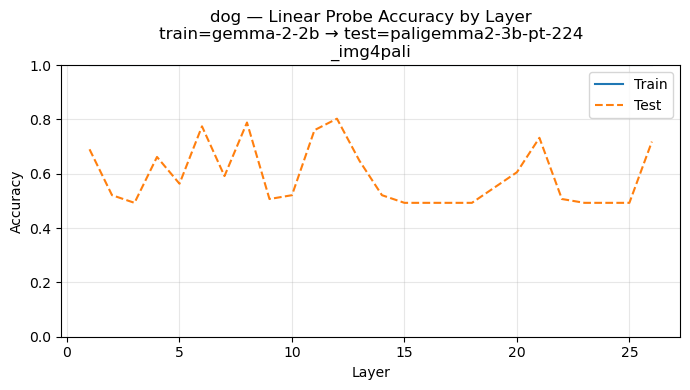


Running linear probe: dog | train on paligemma2-3b-pt-224 → test on gemma-2-2b


Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00, 56.33it/s]


Running linear probing experiment: cat_dog_classification
Gemma training data: (354, 2304)
PolyGemma test data: (354, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (283, 2304), size of gemma_labels_train: 283
size of polygemma_activations_test: (71, 2304), size of polygemma_labels_test: 71
X_train_flat shape: (283, 2304)
y_train shape: 283
X_test_flat shape: (71, 2304)
y_test shape: 71
[dog] layer 01 | train_acc=1.0000 | test_acc=0.9155
(warn) save_results failed (Circular reference detected); writing minimal JSON.
Running linear probing experiment: cat_dog_classification
Gemma training data: (354, 2304)
PolyGemma test data: (354, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (283, 2304), size of gemma_labels_train: 283
size of polygemma_activations_test: (71, 2304), size of polygemma_labels_test: 71
X_train_flat shape: (283, 2304)
y_train shape: 283
X_test_flat shape: (71, 2304)
y_test shape: 71
[dog] layer 02 | train_acc=1.0000 | test

/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Running linear probing experiment: cat_dog_classification
Gemma training data: (354, 2304)
PolyGemma test data: (354, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (283, 2304), size of gemma_labels_train: 283
size of polygemma_activations_test: (71, 2304), size of polygemma_labels_test: 71
X_train_flat shape: (283, 2304)
y_train shape: 283
X_test_flat shape: (71, 2304)
y_test shape: 71
[dog] layer 08 | train_acc=1.0000 | test_acc=0.4930
(warn) save_results failed (Circular reference detected); writing minimal JSON.


/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Running linear probing experiment: cat_dog_classification
Gemma training data: (354, 2304)
PolyGemma test data: (354, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (283, 2304), size of gemma_labels_train: 283
size of polygemma_activations_test: (71, 2304), size of polygemma_labels_test: 71
X_train_flat shape: (283, 2304)
y_train shape: 283
X_test_flat shape: (71, 2304)
y_test shape: 71
[dog] layer 09 | train_acc=1.0000 | test_acc=0.4930
(warn) save_results failed (Circular reference detected); writing minimal JSON.


/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Running linear probing experiment: cat_dog_classification
Gemma training data: (354, 2304)
PolyGemma test data: (354, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (283, 2304), size of gemma_labels_train: 283
size of polygemma_activations_test: (71, 2304), size of polygemma_labels_test: 71
X_train_flat shape: (283, 2304)
y_train shape: 283
X_test_flat shape: (71, 2304)
y_test shape: 71
[dog] layer 10 | train_acc=1.0000 | test_acc=0.4930
(warn) save_results failed (Circular reference detected); writing minimal JSON.


/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Running linear probing experiment: cat_dog_classification
Gemma training data: (354, 2304)
PolyGemma test data: (354, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (283, 2304), size of gemma_labels_train: 283
size of polygemma_activations_test: (71, 2304), size of polygemma_labels_test: 71
X_train_flat shape: (283, 2304)
y_train shape: 283
X_test_flat shape: (71, 2304)
y_test shape: 71
[dog] layer 11 | train_acc=1.0000 | test_acc=0.8028
(warn) save_results failed (Circular reference detected); writing minimal JSON.
Running linear probing experiment: cat_dog_classification
Gemma training data: (354, 2304)
PolyGemma test data: (354, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (283, 2304), size of gemma_labels_train: 283
size of polygemma_activations_test: (71, 2304), size of polygemma_labels_test: 71
X_train_flat shape: (283, 2304)
y_train shape: 283
X_test_flat shape: (71, 2304)
y_test shape: 71
[dog] layer 12 | train_acc=1.0000 | test

/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Running linear probing experiment: cat_dog_classification
Gemma training data: (354, 2304)
PolyGemma test data: (354, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (283, 2304), size of gemma_labels_train: 283
size of polygemma_activations_test: (71, 2304), size of polygemma_labels_test: 71
X_train_flat shape: (283, 2304)
y_train shape: 283
X_test_flat shape: (71, 2304)
y_test shape: 71
[dog] layer 16 | train_acc=1.0000 | test_acc=0.5070
(warn) save_results failed (Circular reference detected); writing minimal JSON.


/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Running linear probing experiment: cat_dog_classification
Gemma training data: (354, 2304)
PolyGemma test data: (354, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (283, 2304), size of gemma_labels_train: 283
size of polygemma_activations_test: (71, 2304), size of polygemma_labels_test: 71
X_train_flat shape: (283, 2304)
y_train shape: 283
X_test_flat shape: (71, 2304)
y_test shape: 71
[dog] layer 17 | train_acc=1.0000 | test_acc=0.8028
(warn) save_results failed (Circular reference detected); writing minimal JSON.
Running linear probing experiment: cat_dog_classification
Gemma training data: (354, 2304)
PolyGemma test data: (354, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (283, 2304), size of gemma_labels_train: 283
size of polygemma_activations_test: (71, 2304), size of polygemma_labels_test: 71
X_train_flat shape: (283, 2304)
y_train shape: 283
X_test_flat shape: (71, 2304)
y_test shape: 71
[dog] layer 18 | train_acc=1.0000 | test

/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Running linear probing experiment: cat_dog_classification
Gemma training data: (354, 2304)
PolyGemma test data: (354, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (283, 2304), size of gemma_labels_train: 283
size of polygemma_activations_test: (71, 2304), size of polygemma_labels_test: 71
X_train_flat shape: (283, 2304)
y_train shape: 283
X_test_flat shape: (71, 2304)
y_test shape: 71
[dog] layer 26 | train_acc=1.0000 | test_acc=0.6338
(warn) save_results failed (Circular reference detected); writing minimal JSON.


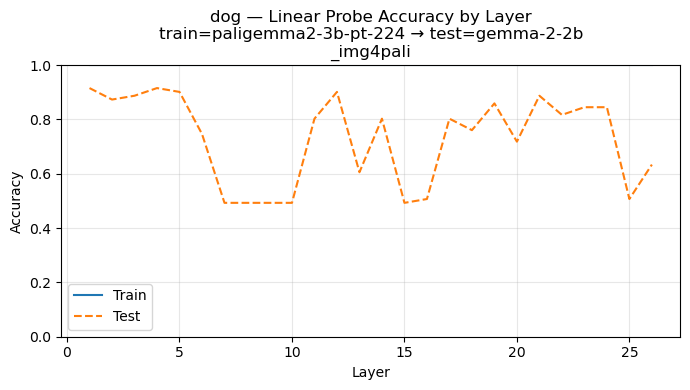


Running linear probe: dog | train on paligemma2-3b-pt-224 → test on paligemma2-3b-pt-224


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]


Running linear probing experiment: cat_dog_classification
Gemma training data: (354, 2304)
PolyGemma test data: (354, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (283, 2304), size of gemma_labels_train: 283
size of polygemma_activations_test: (71, 2304), size of polygemma_labels_test: 71
X_train_flat shape: (283, 2304)
y_train shape: 283
X_test_flat shape: (71, 2304)
y_test shape: 71
[dog] layer 01 | train_acc=1.0000 | test_acc=0.9014
(warn) save_results failed (Circular reference detected); writing minimal JSON.
Running linear probing experiment: cat_dog_classification
Gemma training data: (354, 2304)
PolyGemma test data: (354, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (283, 2304), size of gemma_labels_train: 283
size of polygemma_activations_test: (71, 2304), size of polygemma_labels_test: 71
X_train_flat shape: (283, 2304)
y_train shape: 283
X_test_flat shape: (71, 2304)
y_test shape: 71
[dog] layer 02 | train_acc=1.0000 | test

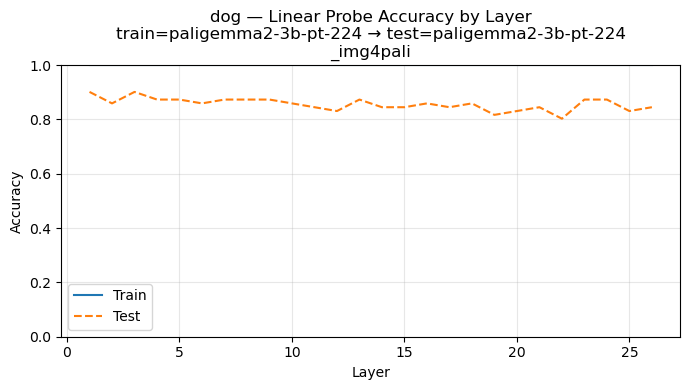


=== Concept: human ===

Running linear probe: human | train on gemma-2-2b → test on gemma-2-2b


Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00, 57.42it/s]


Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (800, 2304), size of gemma_labels_train: 800
size of polygemma_activations_test: (200, 2304), size of polygemma_labels_test: 200
X_train_flat shape: (800, 2304)
y_train shape: 800
X_test_flat shape: (200, 2304)
y_test shape: 200
[human] layer 01 | train_acc=1.0000 | test_acc=0.8750
(warn) save_results failed (Circular reference detected); writing minimal JSON.
Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (800, 2304), size of gemma_labels_train: 800
size of polygemma_activations_test: (200, 2304), size of polygemma_labels_test: 200
X_train_flat shape: (800, 2304)
y_train shape: 800
X_test_flat shape: (200, 2304)
y_test shape: 200
[human] layer 02 | train_a

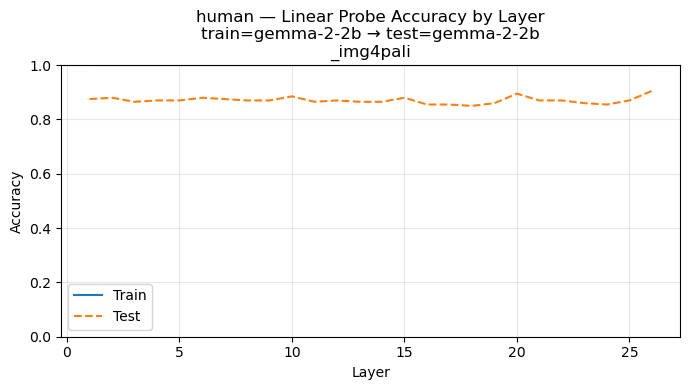


Running linear probe: human | train on gemma-2-2b → test on paligemma2-3b-pt-224


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (800, 2304), size of gemma_labels_train: 800
size of polygemma_activations_test: (200, 2304), size of polygemma_labels_test: 200
X_train_flat shape: (800, 2304)
y_train shape: 800
X_test_flat shape: (200, 2304)
y_test shape: 200
[human] layer 01 | train_acc=1.0000 | test_acc=0.8200
(warn) save_results failed (Circular reference detected); writing minimal JSON.
Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (800, 2304), size of gemma_labels_train: 800
size of polygemma_activations_test: (200, 2304), size of polygemma_labels_test: 200
X_train_flat shape: (800, 2304)
y_train shape: 800
X_test_flat shape: (200, 2304)
y_test shape: 200
[human] layer 02 | train_a

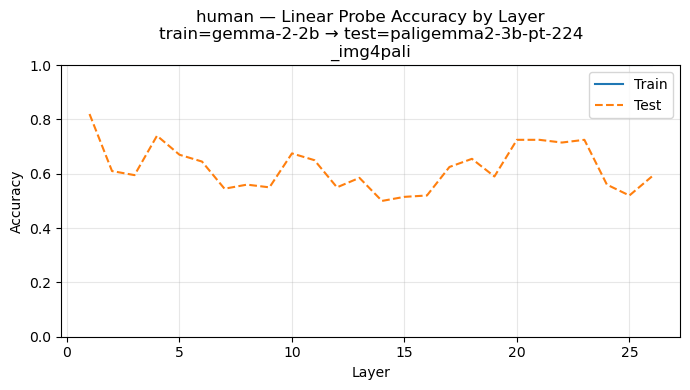


Running linear probe: human | train on paligemma2-3b-pt-224 → test on gemma-2-2b


Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00, 57.35it/s]


Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (800, 2304), size of gemma_labels_train: 800
size of polygemma_activations_test: (200, 2304), size of polygemma_labels_test: 200
X_train_flat shape: (800, 2304)
y_train shape: 800
X_test_flat shape: (200, 2304)
y_test shape: 200
[human] layer 01 | train_acc=1.0000 | test_acc=0.4850
(warn) save_results failed (Circular reference detected); writing minimal JSON.


/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (800, 2304), size of gemma_labels_train: 800
size of polygemma_activations_test: (200, 2304), size of polygemma_labels_test: 200
X_train_flat shape: (800, 2304)
y_train shape: 800
X_test_flat shape: (200, 2304)
y_test shape: 200
[human] layer 02 | train_acc=1.0000 | test_acc=0.4950
(warn) save_results failed (Circular reference detected); writing minimal JSON.
Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (800, 2304), size of gemma_labels_train: 800
size of polygemma_activations_test: (200, 2304), size of polygemma_labels_test: 200
X_train_flat shape: (800, 2304)
y_train shape: 800
X_test_flat shape: (200, 2304)
y_test shape: 200
[human] layer 03 | train_a

/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (800, 2304), size of gemma_labels_train: 800
size of polygemma_activations_test: (200, 2304), size of polygemma_labels_test: 200
X_train_flat shape: (800, 2304)
y_train shape: 800
X_test_flat shape: (200, 2304)
y_test shape: 200
[human] layer 04 | train_acc=1.0000 | test_acc=0.4850
(warn) save_results failed (Circular reference detected); writing minimal JSON.


/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (800, 2304), size of gemma_labels_train: 800
size of polygemma_activations_test: (200, 2304), size of polygemma_labels_test: 200
X_train_flat shape: (800, 2304)
y_train shape: 800
X_test_flat shape: (200, 2304)
y_test shape: 200
[human] layer 05 | train_acc=1.0000 | test_acc=0.4850
(warn) save_results failed (Circular reference detected); writing minimal JSON.


/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (800, 2304), size of gemma_labels_train: 800
size of polygemma_activations_test: (200, 2304), size of polygemma_labels_test: 200
X_train_flat shape: (800, 2304)
y_train shape: 800
X_test_flat shape: (200, 2304)
y_test shape: 200
[human] layer 06 | train_acc=1.0000 | test_acc=0.5000
(warn) save_results failed (Circular reference detected); writing minimal JSON.
Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (800, 2304), size of gemma_labels_train: 800
size of polygemma_activations_test: (200, 2304), size of polygemma_labels_test: 200
X_train_flat shape: (800, 2304)
y_train shape: 800
X_test_flat shape: (200, 2304)
y_test shape: 200
[human] layer 07 | train_a

/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[human] layer 11 | train_acc=1.0000 | test_acc=0.5150
(warn) save_results failed (Circular reference detected); writing minimal JSON.
Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (800, 2304), size of gemma_labels_train: 800
size of polygemma_activations_test: (200, 2304), size of polygemma_labels_test: 200
X_train_flat shape: (800, 2304)
y_train shape: 800
X_test_flat shape: (200, 2304)
y_test shape: 200
[human] layer 12 | train_acc=1.0000 | test_acc=0.8350
(warn) save_results failed (Circular reference detected); writing minimal JSON.
Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (800, 2304), size of gemma_labels_train: 800
size of polygemma_activations_test: (200, 2304), size of polygemma_labels_te

/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (800, 2304), size of gemma_labels_train: 800
size of polygemma_activations_test: (200, 2304), size of polygemma_labels_test: 200
X_train_flat shape: (800, 2304)
y_train shape: 800
X_test_flat shape: (200, 2304)
y_test shape: 200
[human] layer 20 | train_acc=1.0000 | test_acc=0.7750
(warn) save_results failed (Circular reference detected); writing minimal JSON.
Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (800, 2304), size of gemma_labels_train: 800
size of polygemma_activations_test: (200, 2304), size of polygemma_labels_test: 200
X_train_flat shape: (800, 2304)
y_train shape: 800
X_test_flat shape: (200, 2304)
y_test shape: 200
[human] layer 21 | train_a

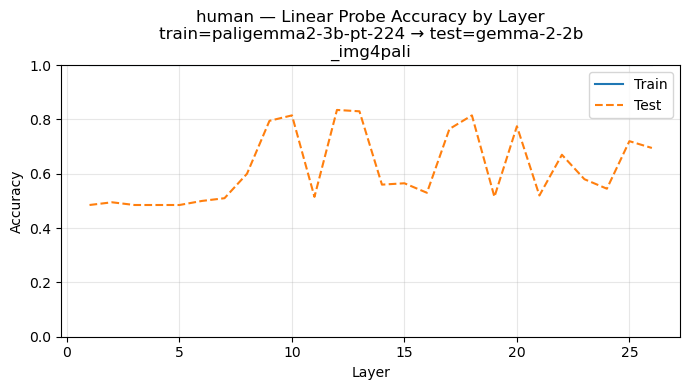


Running linear probe: human | train on paligemma2-3b-pt-224 → test on paligemma2-3b-pt-224


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (800, 2304), size of gemma_labels_train: 800
size of polygemma_activations_test: (200, 2304), size of polygemma_labels_test: 200
X_train_flat shape: (800, 2304)
y_train shape: 800
X_test_flat shape: (200, 2304)
y_test shape: 200
[human] layer 01 | train_acc=1.0000 | test_acc=0.8550
(warn) save_results failed (Circular reference detected); writing minimal JSON.
Running linear probing experiment: cat_dog_classification
Gemma training data: (1000, 2304)
PolyGemma test data: (1000, 2304)

--- Training sklearn probe ---
size of gemma_activations_train: (800, 2304), size of gemma_labels_train: 800
size of polygemma_activations_test: (200, 2304), size of polygemma_labels_test: 200
X_train_flat shape: (800, 2304)
y_train shape: 800
X_test_flat shape: (200, 2304)
y_test shape: 200
[human] layer 02 | train_a

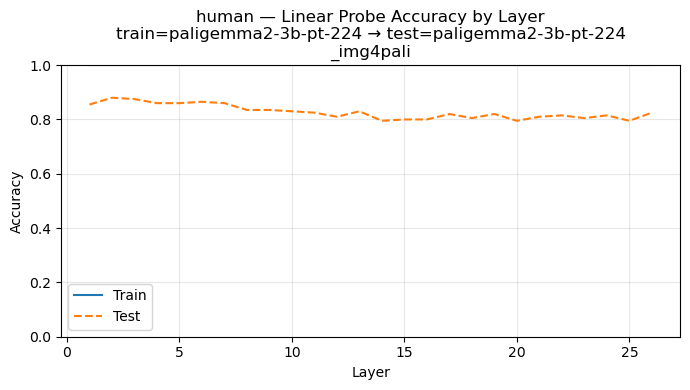

In [50]:
# ========= helpers for this loop =========
from contextlib import nullcontext
from PIL import Image
from transformers import AutoTokenizer, AutoProcessor
import concurrent.futures
def _amp_ctx(device, use_amp=True):
    """Return a context manager for autocast if on CUDA, else a no-op."""
    if not use_amp:
        return nullcontext()
    is_cuda = torch.cuda.is_available() and (
        str(device).startswith("cuda") or getattr(getattr(device, "type", None), "__str__", lambda: "")() == "cuda"
        or (hasattr(device, "type") and device.type == "cuda")
    )
    if not is_cuda:
        return nullcontext()
    # Prefer new API if available
    try:
        return torch.autocast("cuda", dtype=torch.float16)
    except Exception:
        # Fallback for older PyTorch
        return torch.cuda.amp.autocast(dtype=torch.float16)
    
IMG_EXTS = (".jpg", ".jpeg", ".png", ".webp")

def list_filenames(img_root):
    return sorted([fn for fn in os.listdir(img_root) if fn.lower().endswith(IMG_EXTS)])
# --- add this helper ---

def _read_bytes(path: str) -> bytes:
    with open(path, "rb") as f:
        return f.read()

def preload_image_bytes(filenames, root, max_workers: int = 12):
    paths = [os.path.join(root, fn) for fn in filenames]
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as ex:
        data = list(ex.map(_read_bytes, paths))
    return dict(zip(filenames, data))

# REPLACE your get_num_layers(...) with this
def get_num_layers(model):
    """
    Return count of indexable hidden-state layers:
      - If the model has a vision tower, return its depth.
      - Otherwise, return decoder/text depth from model.config.
    Assumes hidden_states = (emb, layer1, ..., layerL) → valid indices 1..L.
    """
    vt = getattr(model, "vision_tower", None)
    if vt is not None:
        # Some VLMs keep the tower in a list/tuple
        if isinstance(vt, (list, tuple)):
            vt = vt[0]
        cfg = getattr(vt, "config", None)
        return int(getattr(cfg, "num_hidden_layers", getattr(cfg, "num_layers", 24)))
    # Text-only models
    cfg = getattr(model, "config", None)
    return int(getattr(cfg, "num_hidden_layers", 26))


_tokenizer_cache = {}
_processor_cache = {}

def _get_tokenizer(model_name):
    if model_name not in _tokenizer_cache:
        _tokenizer_cache[model_name] = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    return _tokenizer_cache[model_name]

def _get_processor(model_name):
    if model_name not in _processor_cache:
        _processor_cache[model_name] = AutoProcessor.from_pretrained(model_name)
    return _processor_cache[model_name]

def _short(name: str):
    return name.split("/")[-1].replace(":", "_")

def get_acts(
    model, texts, layer, model_name, device,
    *,
    filenames=None, img_byte_cache=None,  # only for PaliGemma
    batch_size=32, pool="mean", use_amp=True, max_length=256
):
    """Return (N, D) activations at a specific layer, pooled.
       - Gemma: text forward, layer over decoder hs
       - PaliGemma: vision_tower forward, layer over vision hs
    """
    model.eval()
    feats = []

    if not hasattr(model, "vision_tower"):
        # ------- TEXT path (Gemma) -------
        tok = _get_tokenizer(model_name)
        with torch.inference_mode(), _amp_ctx(device, use_amp):
            for start in range(0, len(texts), batch_size):
                batch = texts[start:start+batch_size]
                enc = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
                enc = {k: v.to(device) for k, v in enc.items()}
                out = model(**enc, output_hidden_states=True, return_dict=True)
                hs = out.hidden_states[layer]  # (B, T, D)  layer index 1..L
                mask = enc["attention_mask"].unsqueeze(-1)  # (B, T, 1)
                if pool == "cls":
                    pooled = hs[:, 0, :]
                elif pool == "last":
                    last_idx = (enc["attention_mask"].sum(dim=1) - 1).clamp(min=0)
                    pooled = hs[torch.arange(hs.size(0), device=hs.device), last_idx, :]
                else:  # mean
                    summed = (hs * mask).sum(dim=1)
                    denom = mask.sum(dim=1).clamp(min=1)
                    pooled = summed / denom
                feats.append(pooled.detach().float().cpu().numpy())
                del out, enc, hs
                torch.cuda.empty_cache()
    else:
        # ------- IMAGE path (PaliGemma vision tower) -------
        assert filenames is not None and img_byte_cache is not None, "PaliGemma path needs filenames & img_byte_cache."
        proc = _get_processor(model_name)
        # make sure the tower emits hidden states
        try:
            model.vision_tower.config.output_hidden_states = True
        except Exception:
            pass

        with torch.inference_mode(), _amp_ctx(device, use_amp):
            for start in range(0, len(filenames), batch_size):
                fnb = filenames[start:start+batch_size]
                imgs = [Image.open(io.BytesIO(img_byte_cache[fn])).convert("RGB") for fn in fnb]
                enc = proc(images=imgs, return_tensors="pt")
                px = enc["pixel_values"].to(device, non_blocking=True)
                vout = model.vision_tower(pixel_values=px, output_hidden_states=True, return_dict=True)
                hs = vout.hidden_states[layer]  # (B, N_tokens, D)  layer index 1..L
                if pool == "cls" and hs.size(1) >= 1:
                    pooled = hs[:, 0, :]
                elif pool == "last" and hs.size(1) >= 1:
                    pooled = hs[:, -1, :]
                else:
                    pooled = hs.mean(dim=1)  # robust across ViT/SigLIP-like towers
                feats.append(pooled.detach().float().cpu().numpy())
                del vout, enc, px, imgs, hs
                torch.cuda.empty_cache()

    return np.concatenate(feats, axis=0)
# ========= end helpers =========


# =======================
#        MAIN LOOP
# =======================
model1_names = ["google/gemma-2-2b", "google/paligemma2-3b-pt-224"]
model2_names = ["google/gemma-2-2b", "google/paligemma2-3b-pt-224"]
data_name_list = ['cat', 'dog', 'human']

BATCH_SIZE = 32
POOL = "mean"      # or "cls"/"last"
USE_AMP = True
experiment = LinearProbingExperiment(concept="cat_dog_classification")

for texts, labels, data_name in zip(texts_list, labels_list, data_name_list):
    print(f"\n=== Concept: {data_name} ===", flush=True)

    # --- Per-concept image root + filenames + RAM cache (used only by PaliGemma) ---
    IMG_ROOT = f"../data/coco_val2017_{data_name}_binary_with_captions_balanced_images"
    filenames = list_filenames(IMG_ROOT)

    # Align counts conservatively across texts/labels/images
    N = min(len(texts), len(labels), len(filenames)) if len(filenames) > 0 else min(len(texts), len(labels))
    if N < len(texts) or N < len(labels):
        print(f"(warn) Truncating to N={N} to keep text/label/image lengths aligned.", flush=True)
    texts   = texts[:N]
    labels  = labels[:N]
    filenames = filenames[:N]

    img_byte_cache = preload_image_bytes(filenames, IMG_ROOT, max_workers=12) if len(filenames) else None

    for model1_name in model1_names:
        for model2_name in model2_names:
            print(f"\nRunning linear probe: {data_name} | train on {_short(model1_name)} → test on {_short(model2_name)}", flush=True)

            model1 = load_models_with_eval(model1_name, DEVICE_1)
            model2 = load_models_with_eval(model2_name, DEVICE_2)

            # --- Shared layer range (decoder for Gemma, vision for PaliGemma) ---
            L1 = get_num_layers(model1)
            L2 = get_num_layers(model2)
            layer_to_test = list(range(1, min(L1, L2) + 1))

            all_results = []
            train_accs, test_accs = [], []

            for layer in layer_to_test:
                with torch.inference_mode():
                    act1 = get_acts(
                        model1, texts, layer, model1_name, DEVICE_1,
                        filenames=filenames if "pali" in model1_name.lower() else None,
                        img_byte_cache=img_byte_cache if "pali" in model1_name.lower() else None,
                        batch_size=BATCH_SIZE, pool=POOL, use_amp=USE_AMP
                    )
                    act2 = get_acts(
                        model2, texts, layer, model2_name, DEVICE_2,
                        filenames=filenames if "pali" in model2_name.lower() else None,
                        img_byte_cache=img_byte_cache if "pali" in model2_name.lower() else None,
                        batch_size=BATCH_SIZE, pool=POOL, use_amp=USE_AMP
                    )

                # === Run probe experiment ===
                results = experiment.run_experiment(
                    act1, labels,
                    act2, labels
                )
                all_results.append(results)

                tr = results[1]['sklearn']['train_acc']
                te = results[1]['sklearn']['test_acc']
                train_accs.append(tr); test_accs.append(te)

                print(f"[{data_name}] layer {layer:02d} | train_acc={tr:.4f} | test_acc={te:.4f}")
                # Print (optional) report line
                # print(results[1]['sklearn']['classification_report'])

                # ---- Save results ----
                os.makedirs(f"../output/{data_name}", exist_ok=True)
                tag = f"{_short(model1_name)}_{_short(model2_name)}_img4pali"
                out_json = f"../output/{data_name}/linear_probing_results_layer{layer:02d}_{tag}.json"
                try:
                    experiment.save_results(results, out_json)
                except Exception as e:
                    # Fallback minimal JSON if your experiment wrapper expects different fields
                    print(f"(warn) save_results failed ({e}); writing minimal JSON.")
                    ultra = {
                        "meta": {"data": data_name, "layer": int(layer),
                                 "train_model": model1_name, "test_model": model2_name},
                        "train_acc": float(tr),
                        "test_acc":  float(te)
                    }
                    with open(out_json.replace(".json", "_minimal.json"), "w") as f:
                        json.dump(ultra, f, indent=2)

                # ---- Save misclassified examples (use current 'texts') ----
                if 'y_test' in results[1]['sklearn'] and 'y_pred' in results[1]['sklearn']:
                    mis_indices = [i for i, (yt, yp) in enumerate(zip(
                        results[1]['sklearn']['y_test'], results[1]['sklearn']['y_pred']
                    )) if yt != yp]
                    mis_info = [
                        {
                            'text': texts[i],
                            'true_label': int(results[1]['sklearn']['y_test'][i]),
                            'pred_label': int(results[1]['sklearn']['y_pred'][i])
                        }
                        for i in mis_indices
                    ]
                    mis_dir = f"../output/{data_name}/{tag}"
                    os.makedirs(mis_dir, exist_ok=True)
                    with open(os.path.join(mis_dir, f"misclassified_layer_{layer:02d}_img4pali.json"), "w") as f:
                        json.dump(mis_info, f, indent=2)
                else:
                    print("(warn) 'y_test' or 'y_pred' not found; misclassifications not saved.")

                del act1, act2, results
                gc.collect(); torch.cuda.empty_cache()

            # ===== Plot Train and Test Accuracy Across Layers =====
            layers_ = layer_to_test
            plt.figure(figsize=(7, 4))
            plt.plot(layers_, train_accs, label='Train')
            plt.plot(layers_, test_accs,  label='Test', linestyle="--")
            plt.xlabel('Layer'); plt.ylabel('Accuracy')
            plt.title(f"{data_name} — Linear Probe Accuracy by Layer\ntrain={_short(model1_name)} → test={_short(model2_name)}\n_img4pali")
            plt.ylim(0.0, 1.0); plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
            fig_dir = f"../figs_tabs/{data_name}/"
            os.makedirs(fig_dir, exist_ok=True)
            plt.savefig(os.path.join(fig_dir, f"acc_by_layer_{_short(model1_name)}_{_short(model2_name)}_img4pali.png"), dpi=200)
            plt.show(); plt.close()

            # free models
            del model1, model2
            gc.collect(); torch.cuda.empty_cache()
